In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import SimpleITK as sitk
import matplotlib.backends.backend_pdf
import pandas as pd

In [2]:
########## Functions ###########

# Function that plots 4 axial slices (specified or as default) of the selected dose overlayed with a structure
def generate_z_level_plot(dose, structure, positions = (40, 60, 80, 100)):
    """Generates an overlay plot for different positions along the superior-inferior axis.

    Args:
        image_3t (sitk.Image): The 3T image.
        image_7t (sitk.Image: The 7T image.
        positions (Tuple[int, ...]): The positions on the superior-inferior axis to be plotted.

    Returns:
        None
    """
    assert len(positions) == 4, 'The number of positions must be four!'

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    fig.tight_layout()

    for axis, pos in zip(axes.flat, positions):
        axis.imshow(sitk.GetArrayFromImage(dose)[pos, :, :])
        axis.imshow(sitk.GetArrayFromImage(structure)[pos, :, :], alpha = 0.3)

    plt.show()
    plt.close(fig)
    
# function that calculates and plots the DVHs based on the dose array of a specific structure
def calc_dvhs (dose_array_gt, dose_array_pred, case_nr, name):
    bins = np.arange(0, np.ceil(np.max(dose_array_gt)), 0.1)
    total_voxels = len(dose_array_gt)
    values_gt = []
    values_pred = []
    for bin in bins:
        number_gt = (dose_array_gt >= bin).sum()
        number_pred = (dose_array_pred >= bin).sum()
        
        value_gt = number_gt/total_voxels * 100
        value_pred = number_pred/total_voxels * 100
        
        values_gt.append(value_gt)
        values_pred.append(value_pred)
        
    fig = plt.figure()
    plt.plot(bins, values_gt, color = "b", label = "ground truth")
    plt.plot(bins, values_pred, color = "r", label = "prediction")
    
    plt.xlabel('Dose [Gy]')
    plt.ylabel('Ratio of Total Structure Volume [%]')
    plt.title(case_nr + " " + name)
    plt.legend(loc='best')
    
    return(fig)
    

/var/folders/yr/q_0gpqgs1lq_rtbttpk3n9bh0000gn/T/ipykernel_9149/837994049.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


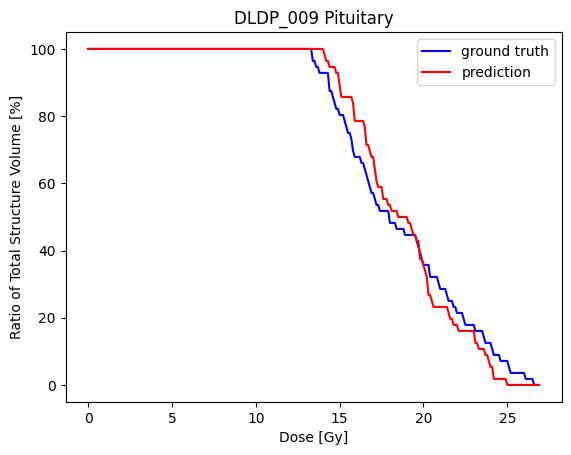

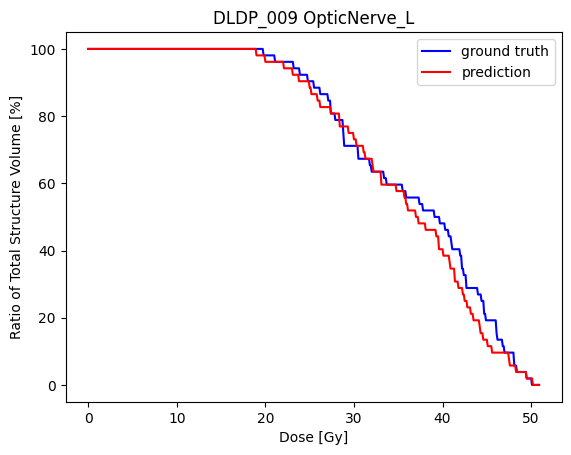

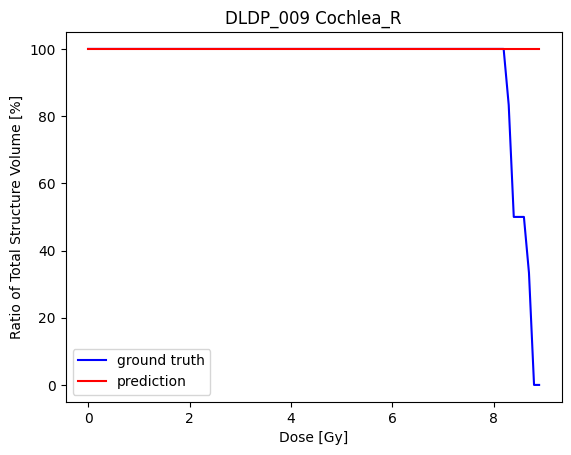

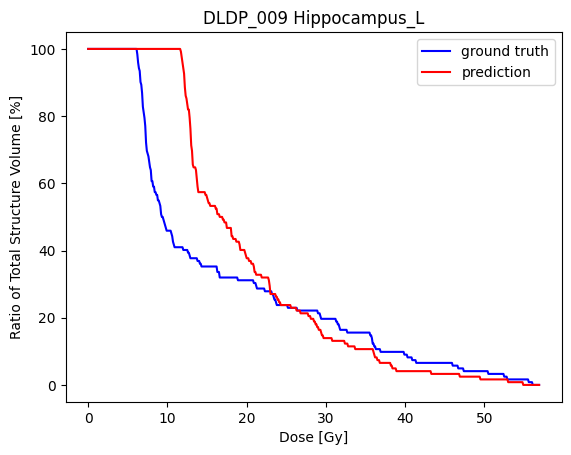

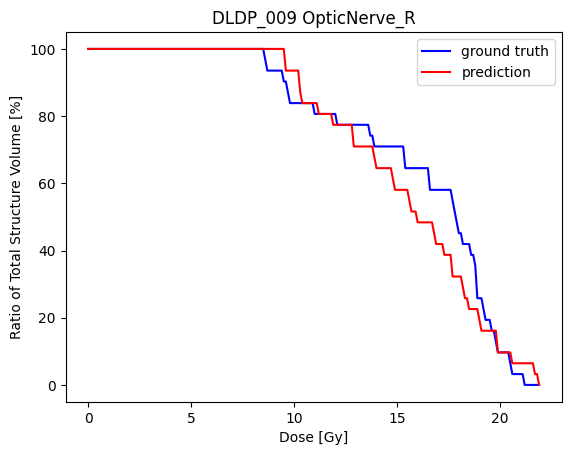

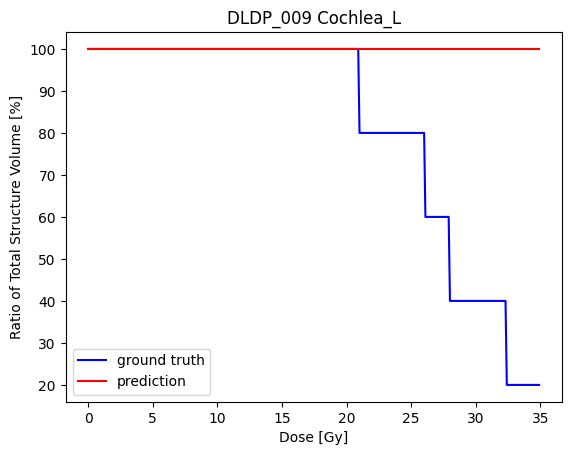

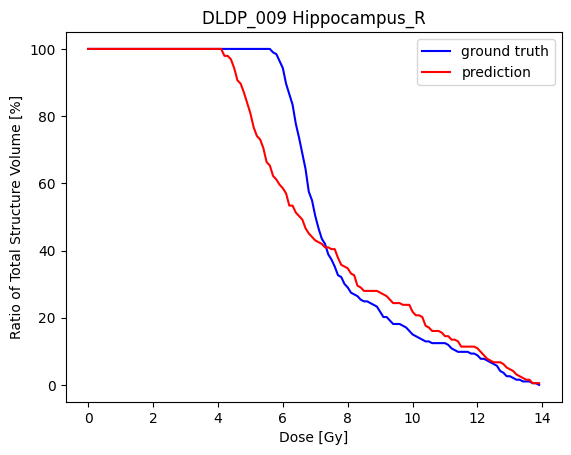

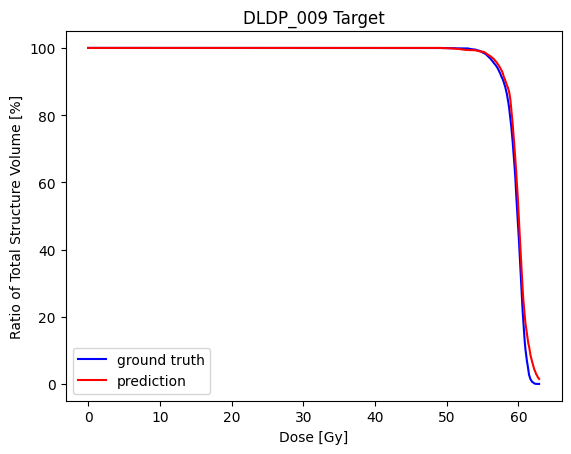

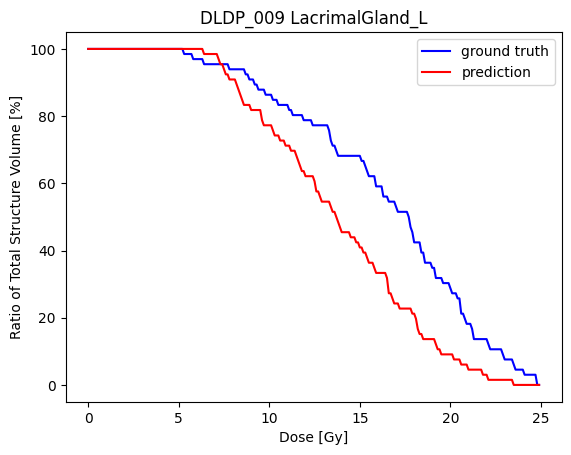

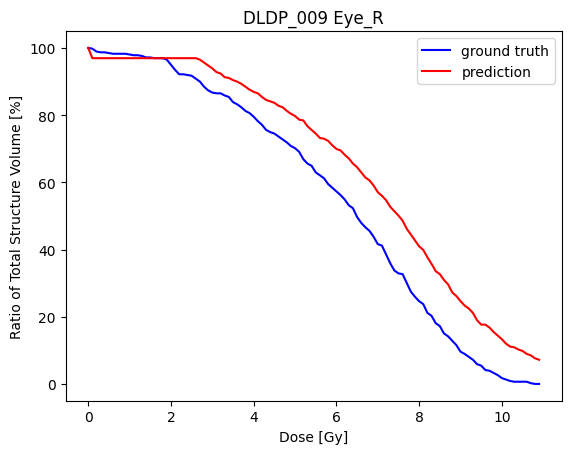

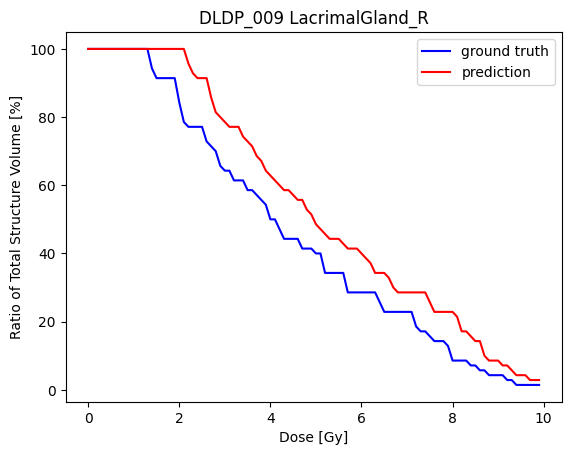

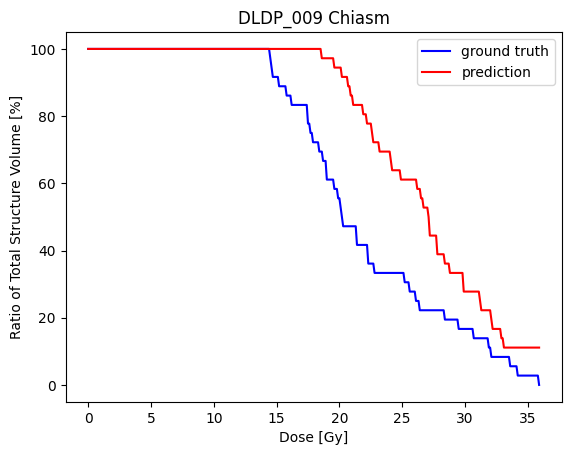

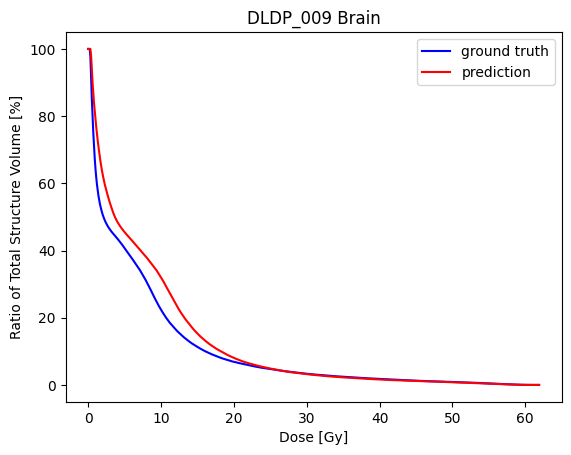

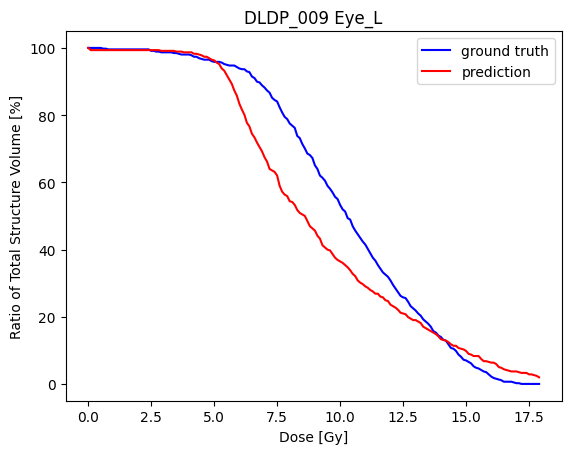

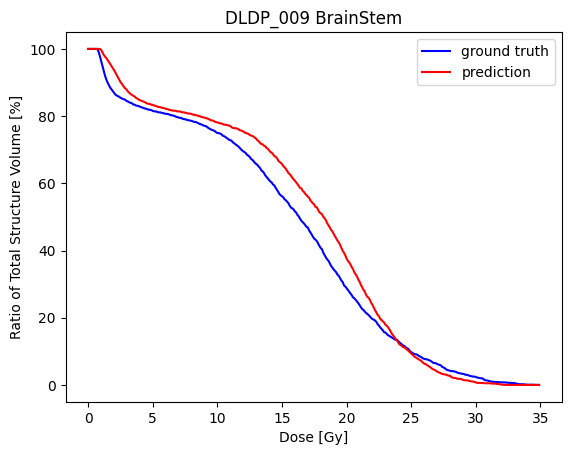

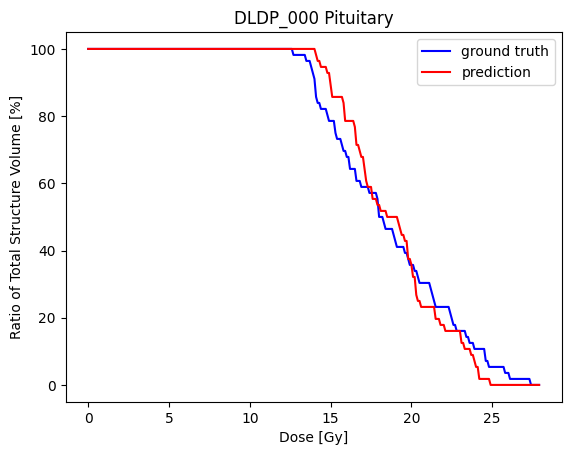

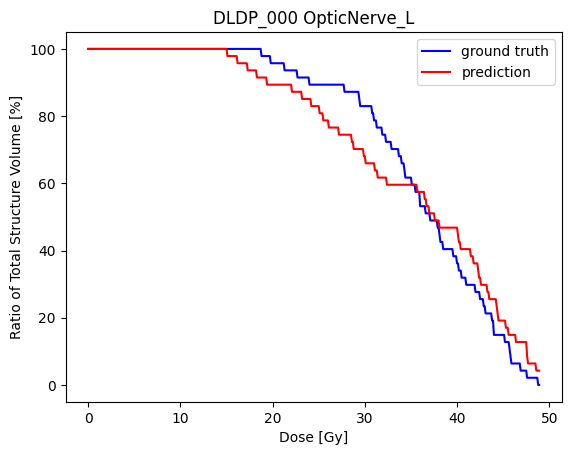

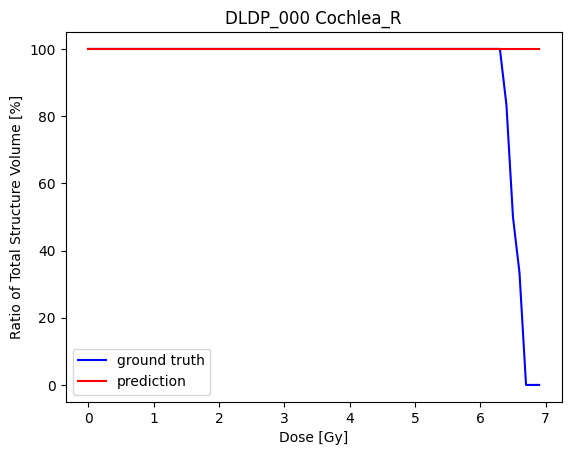

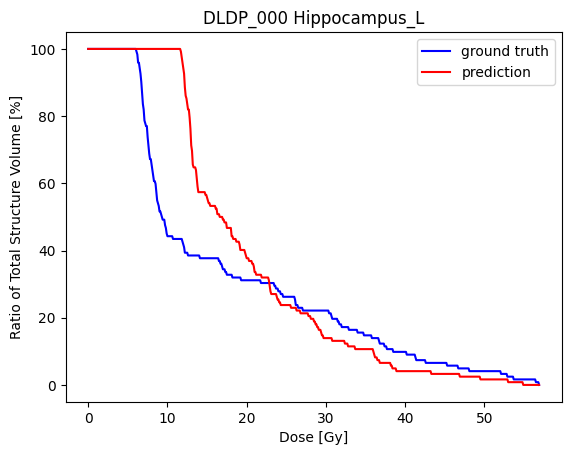

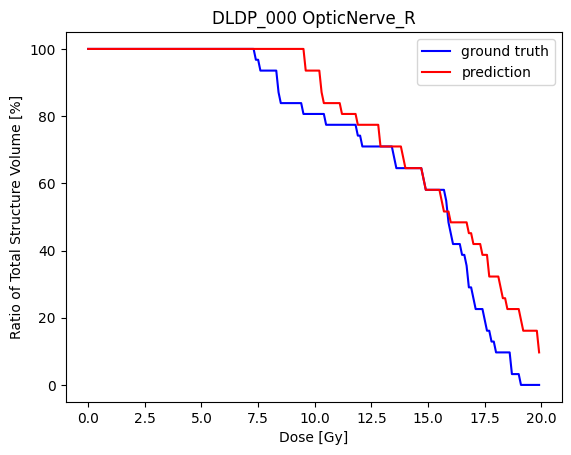

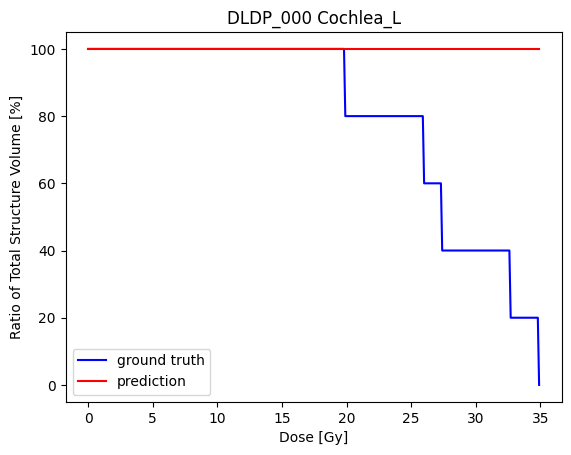

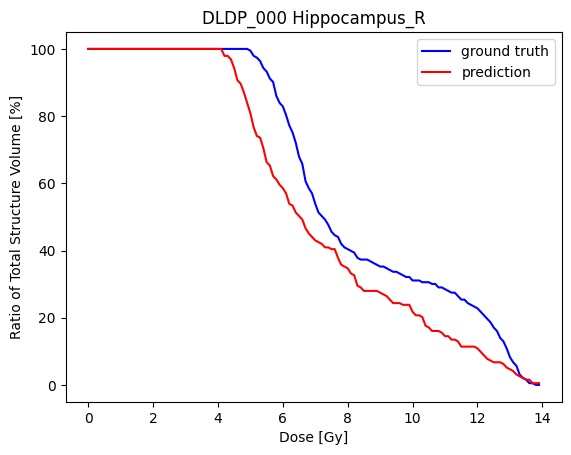

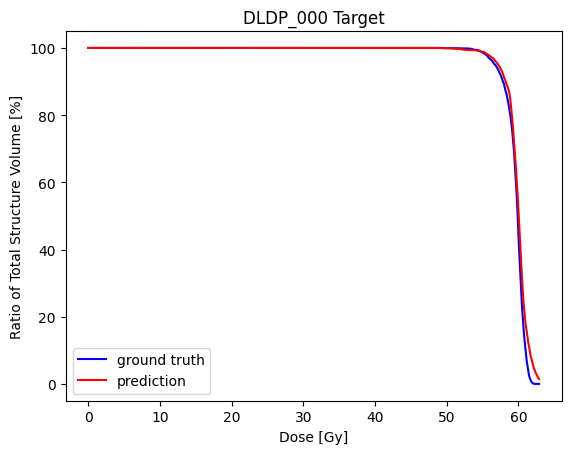

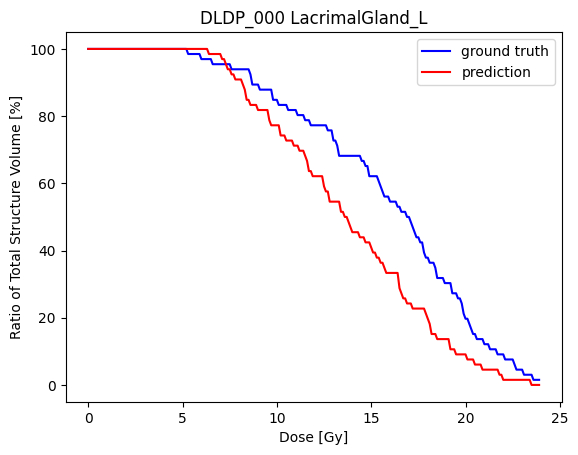

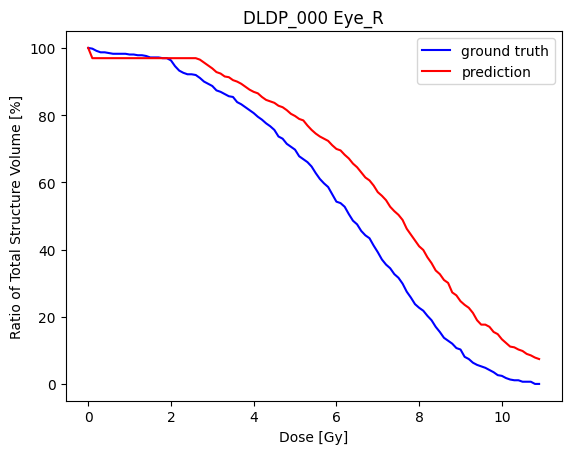

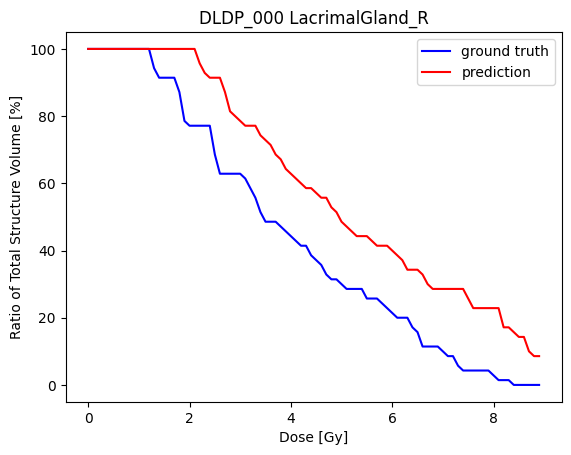

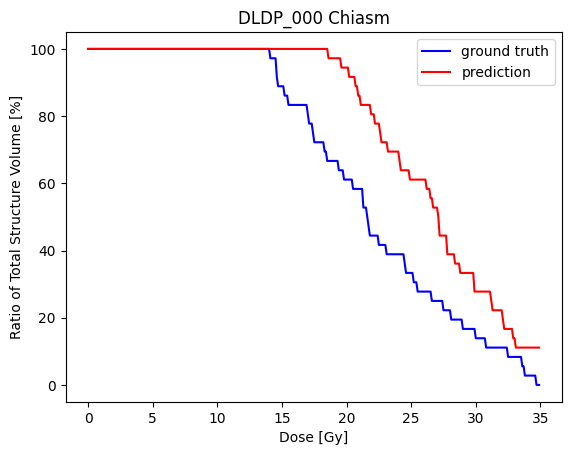

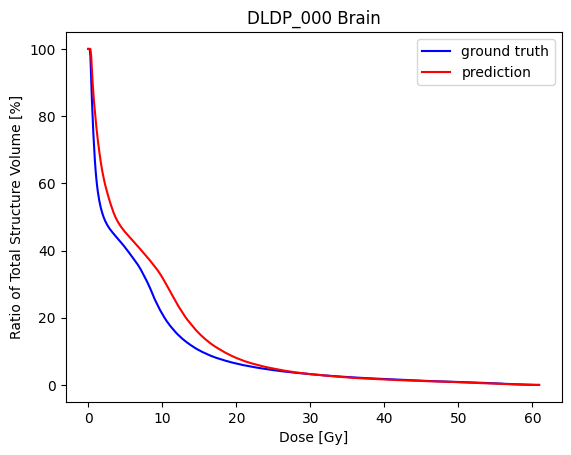

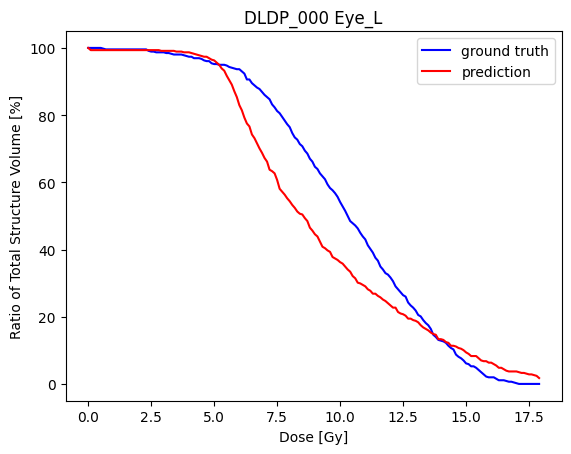

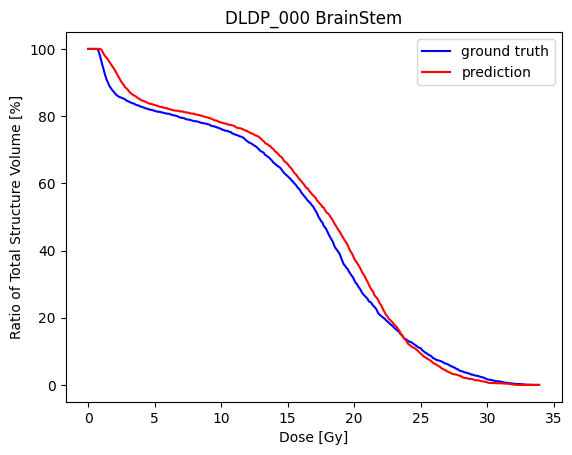

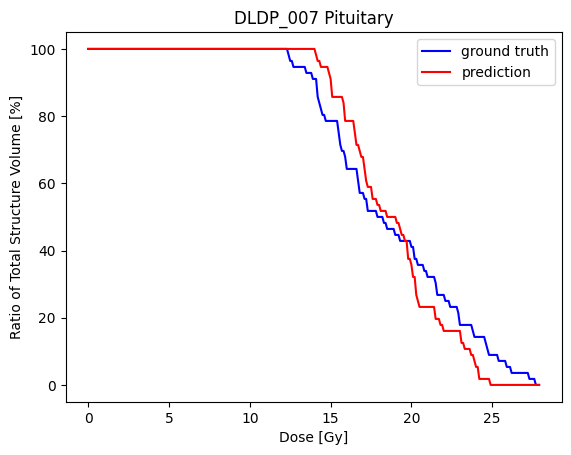

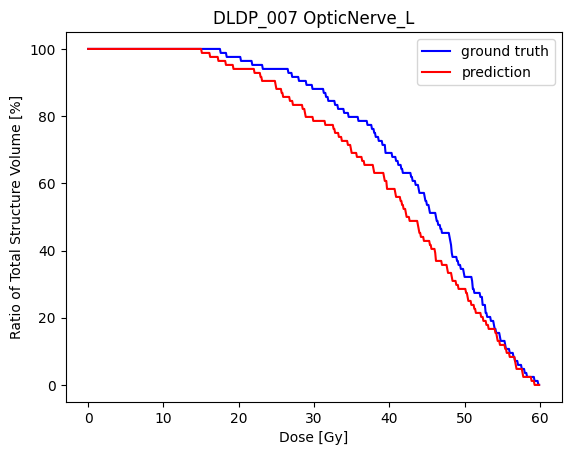

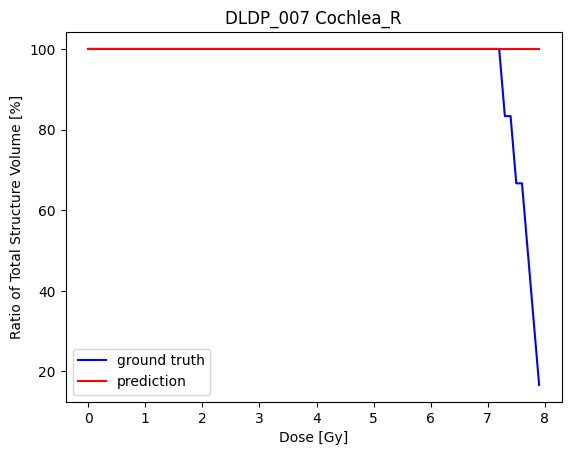

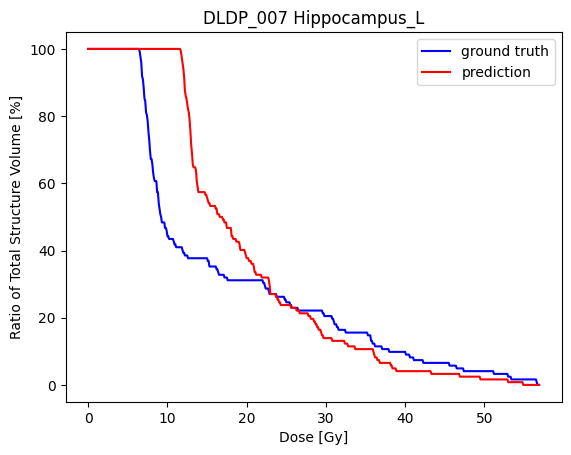

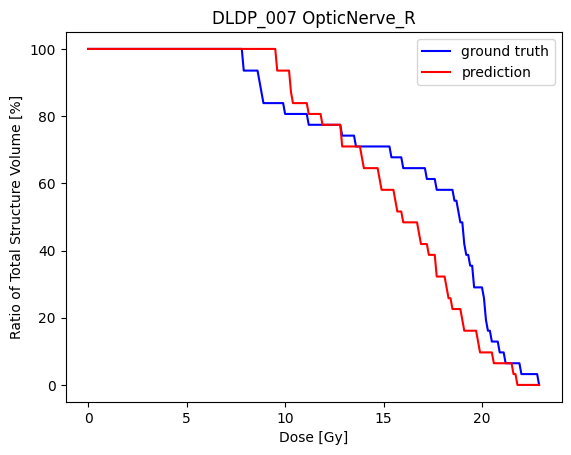

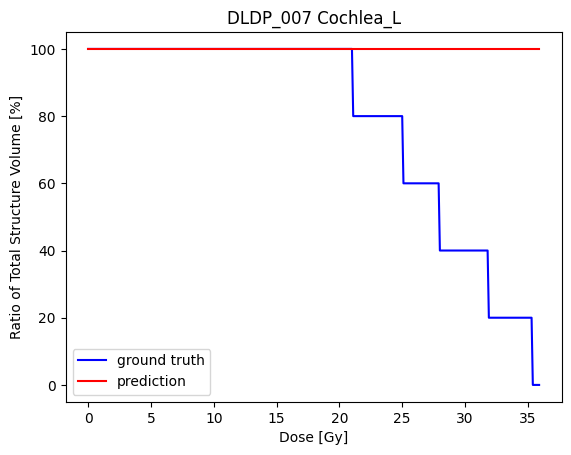

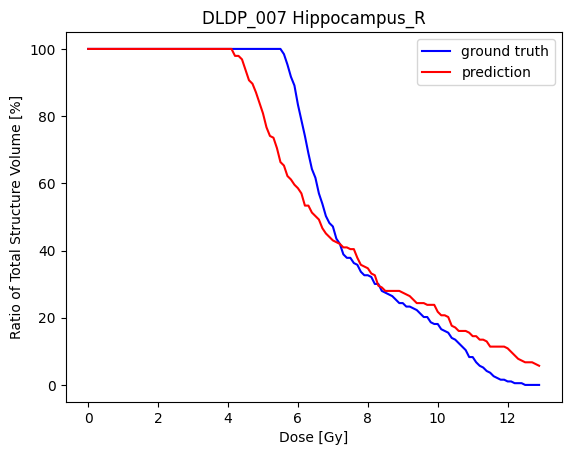

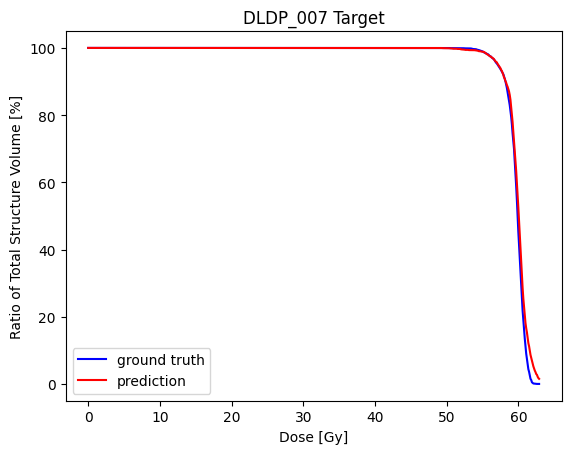

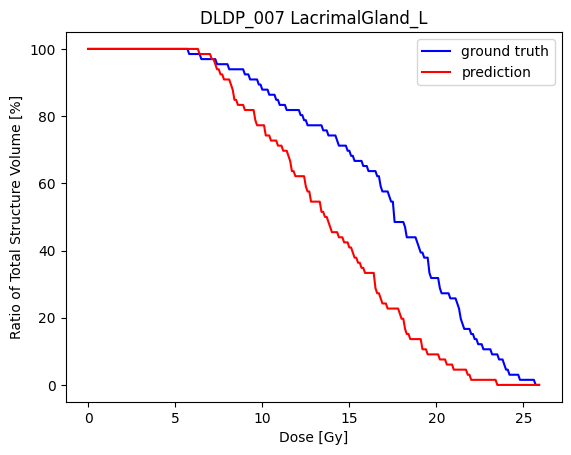

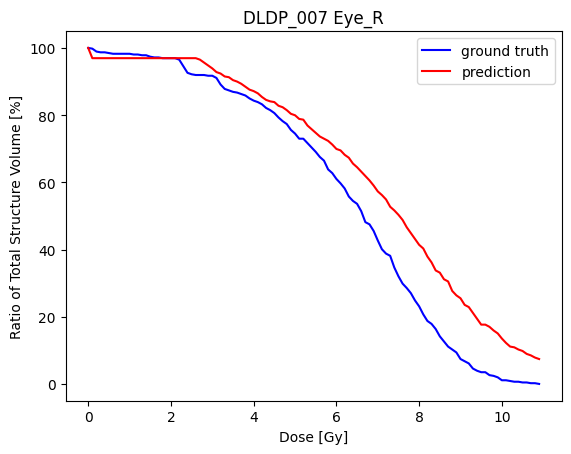

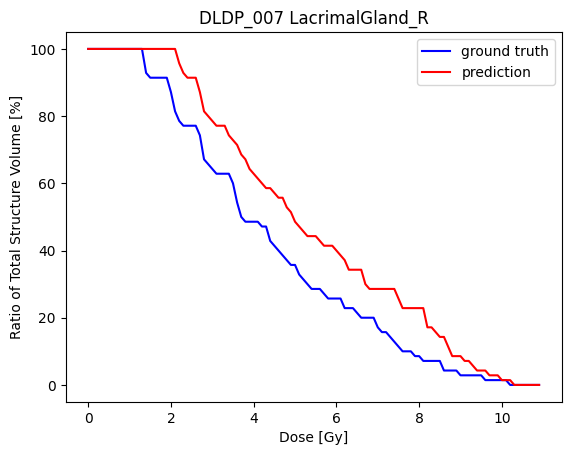

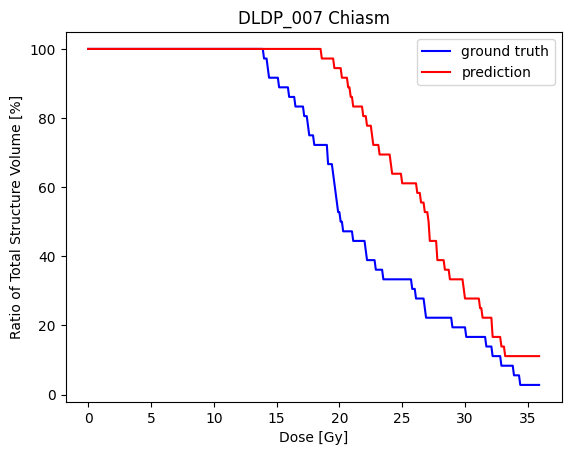

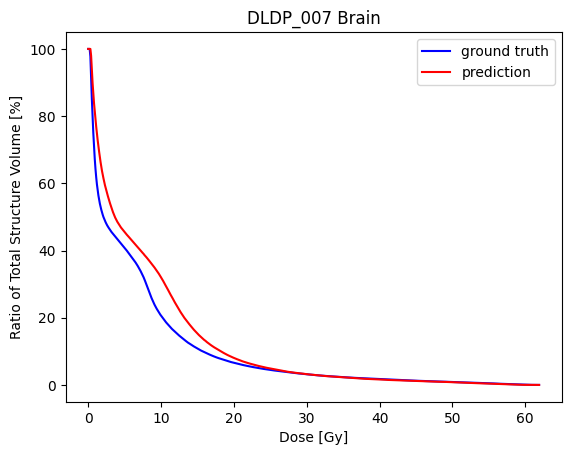

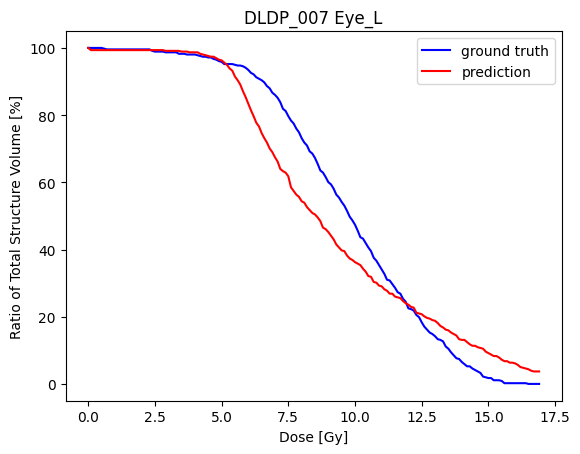

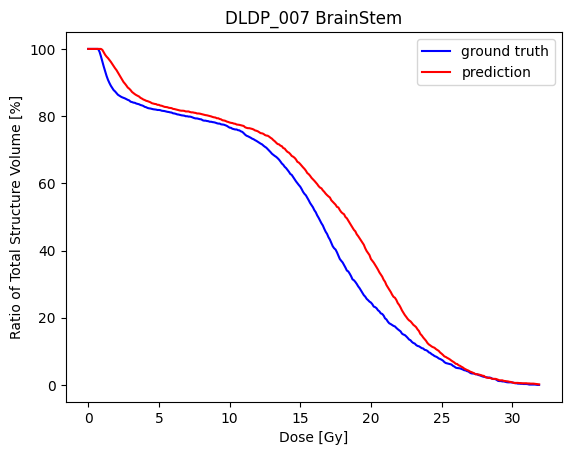

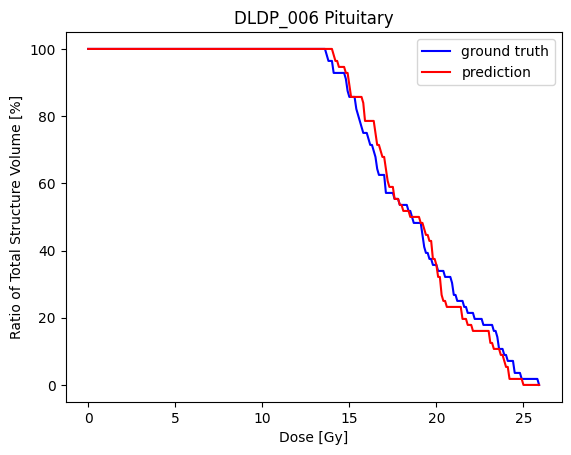

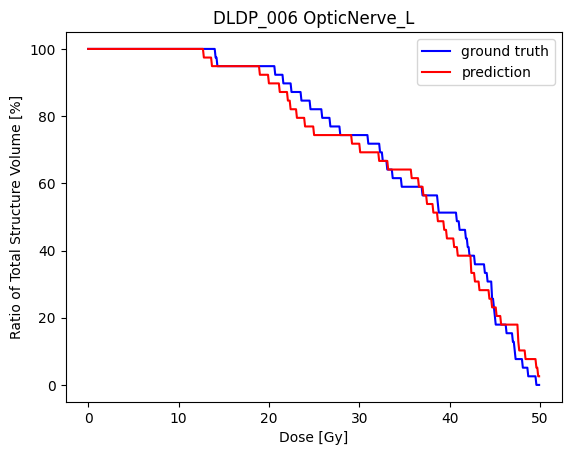

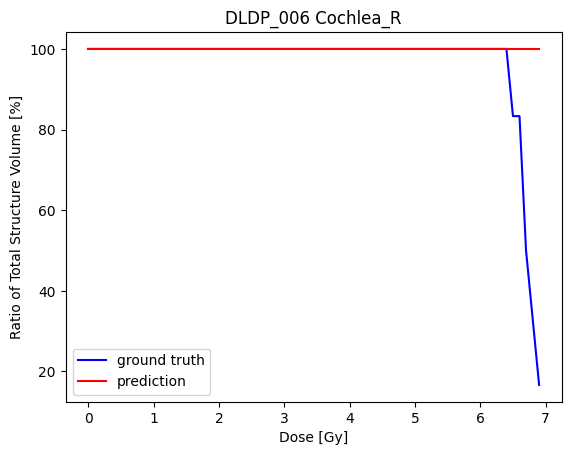

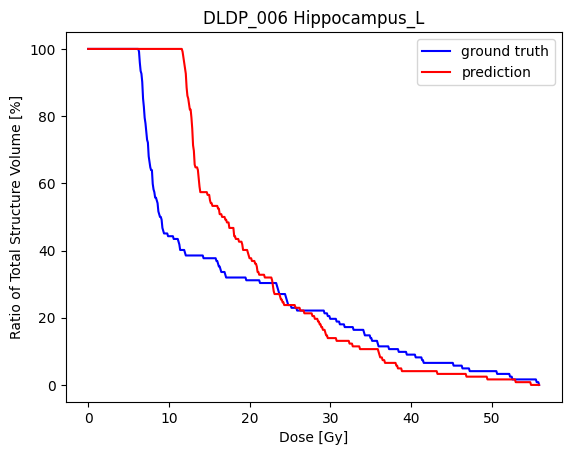

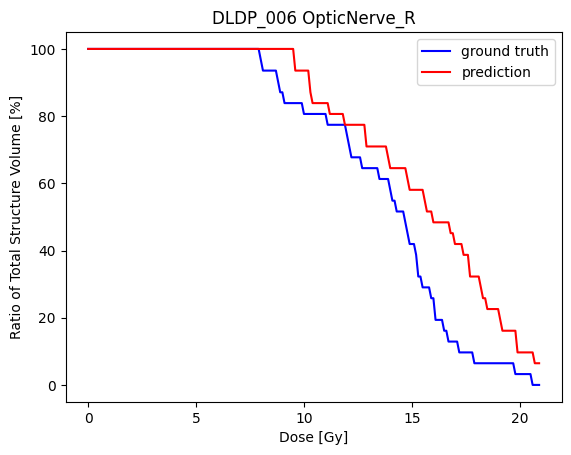

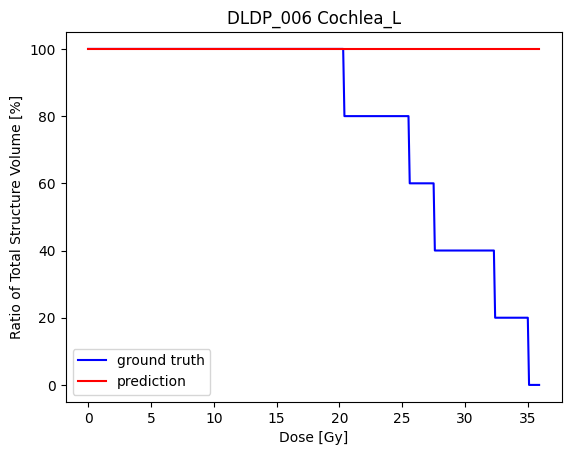

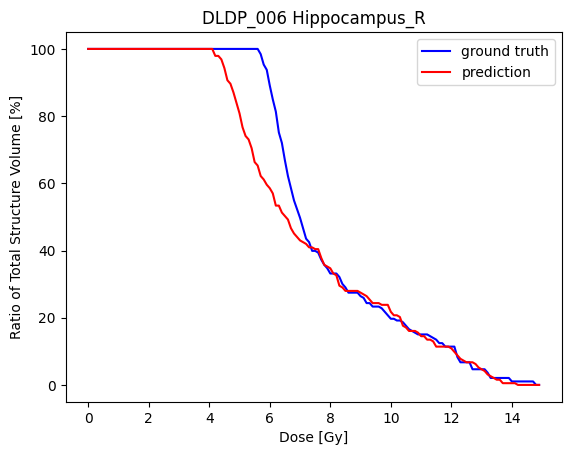

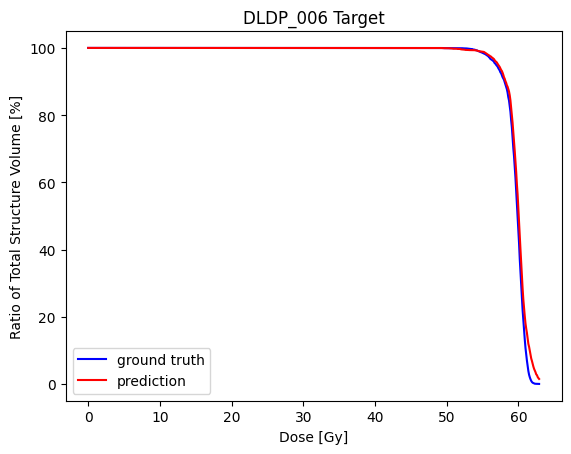

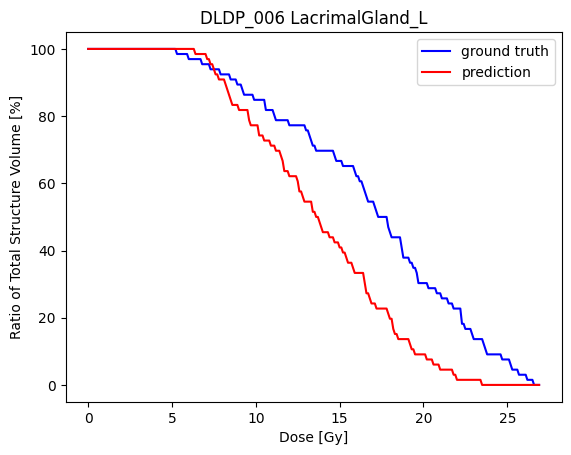

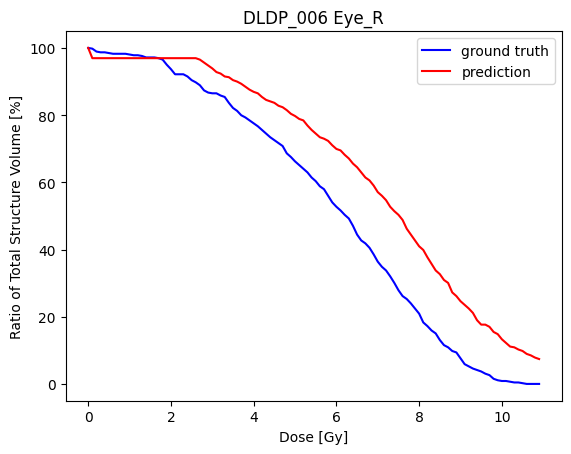

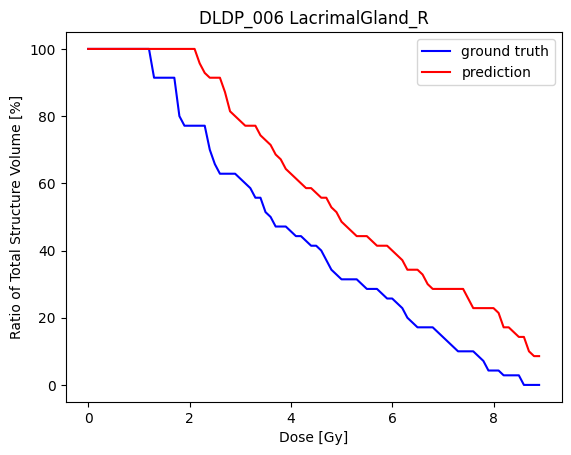

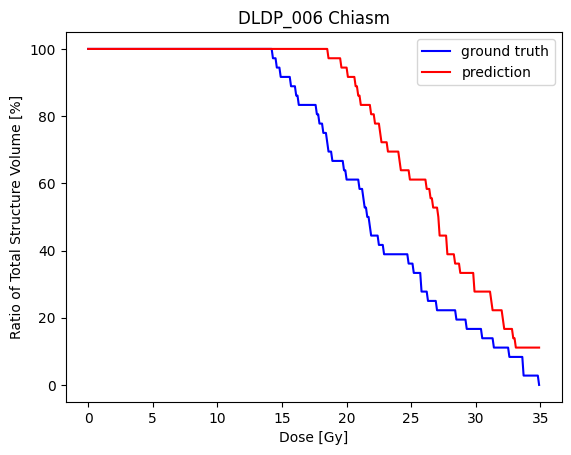

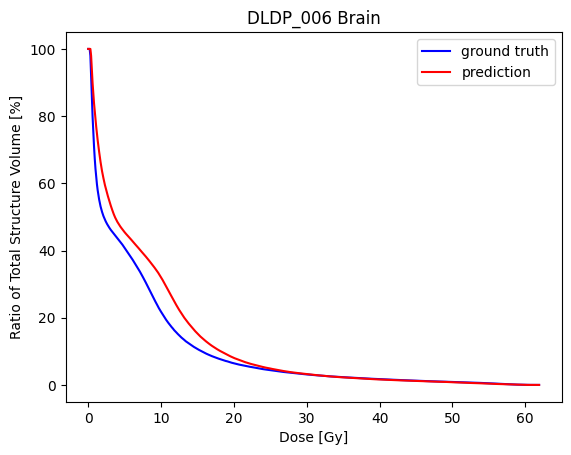

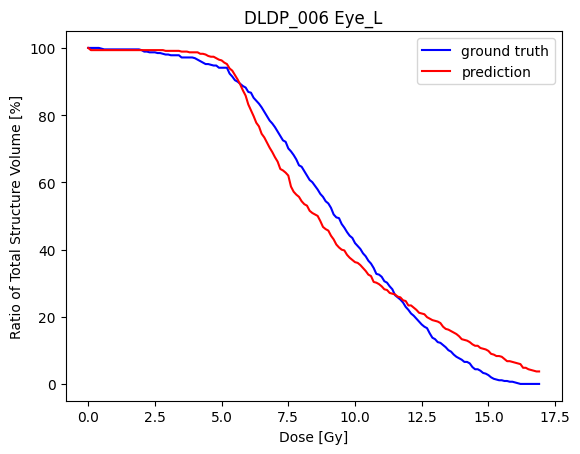

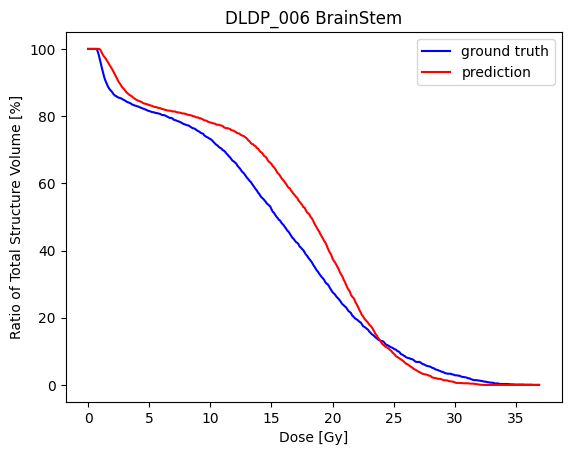

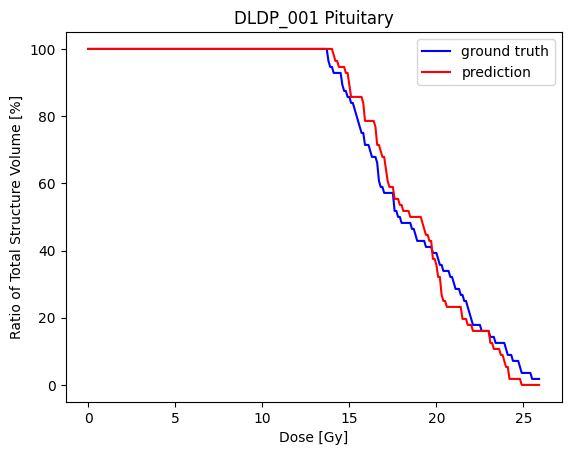

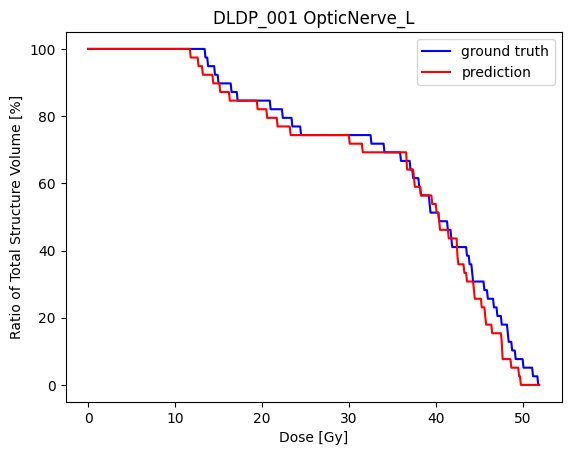

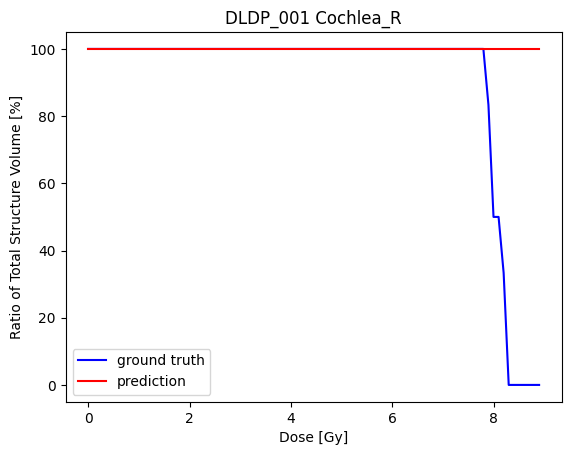

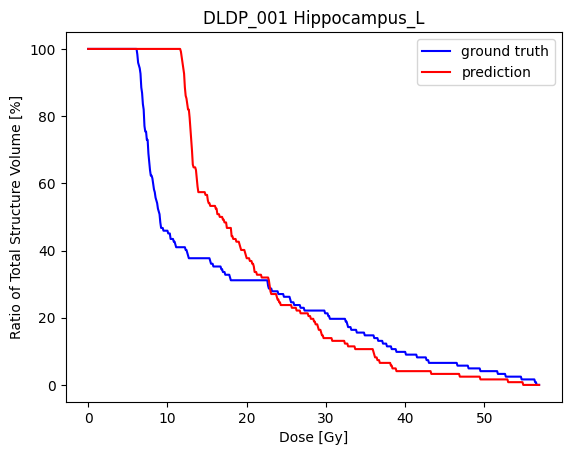

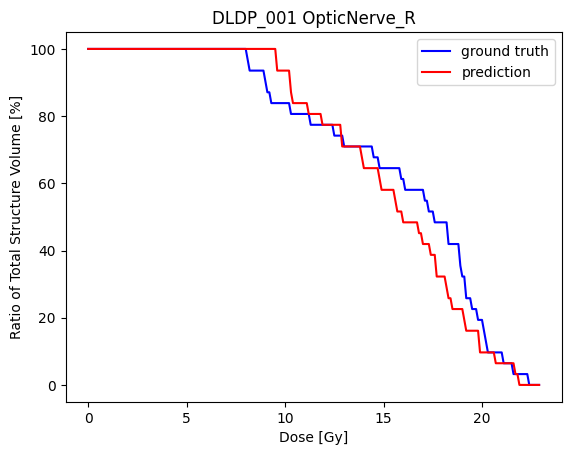

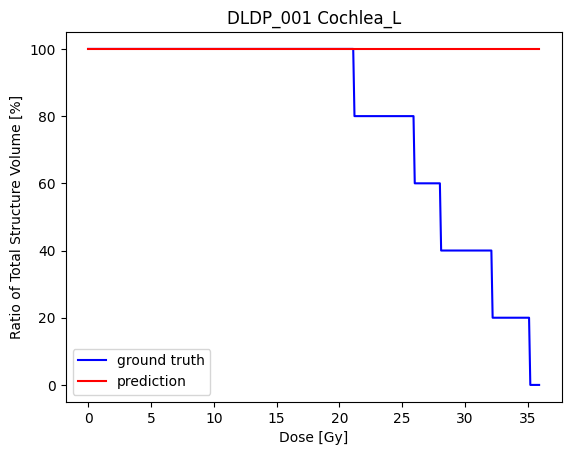

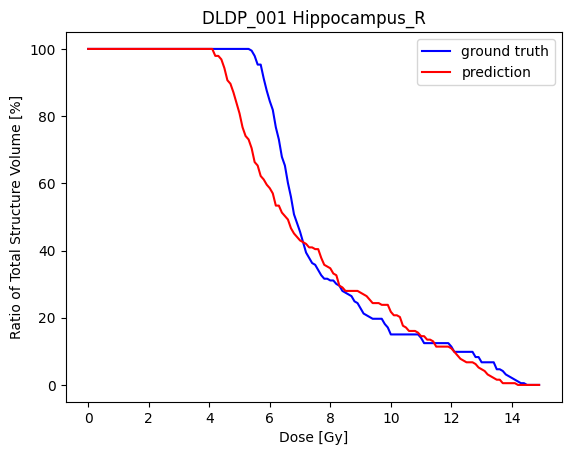

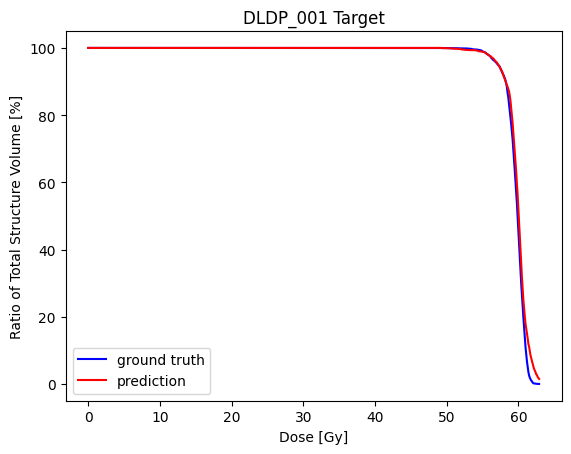

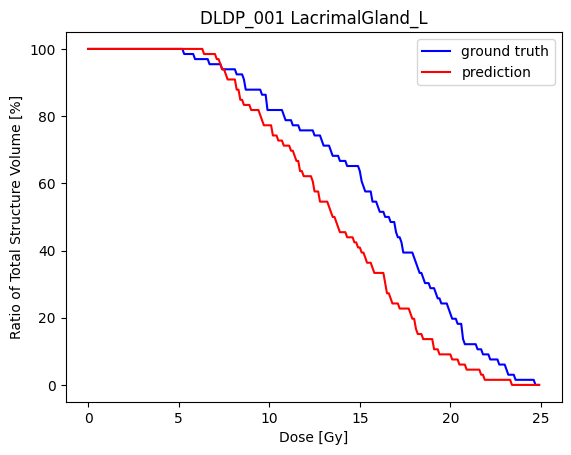

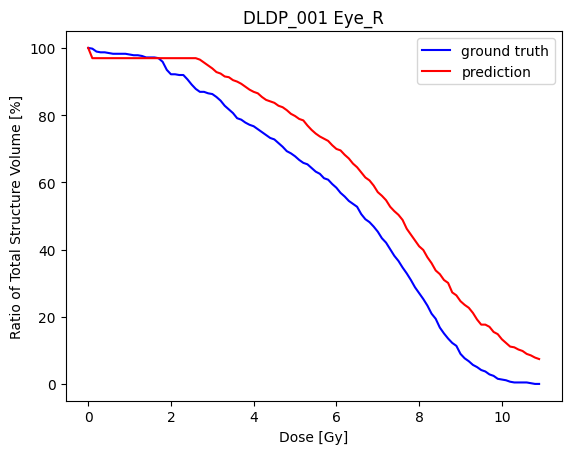

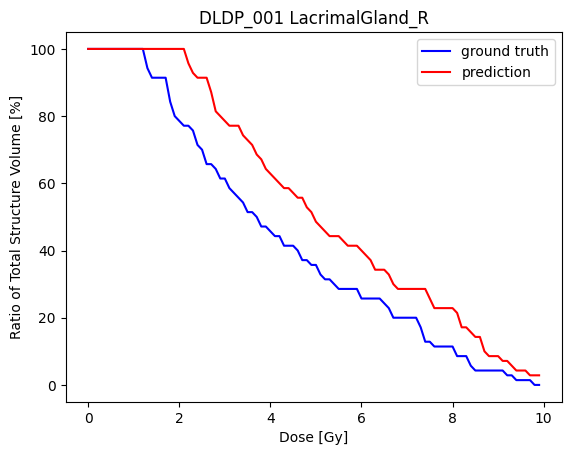

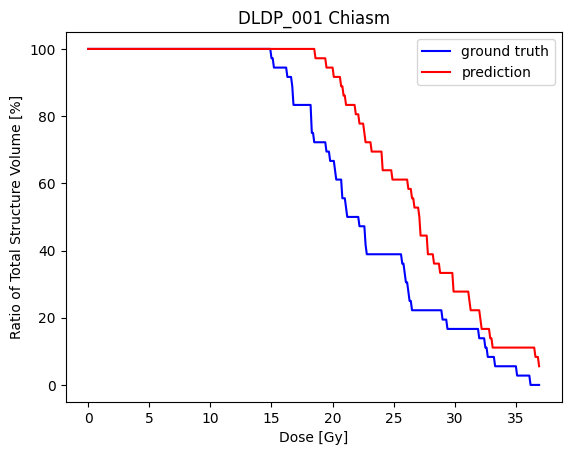

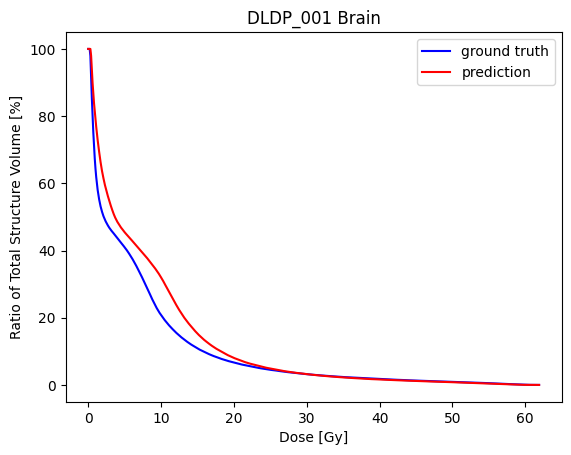

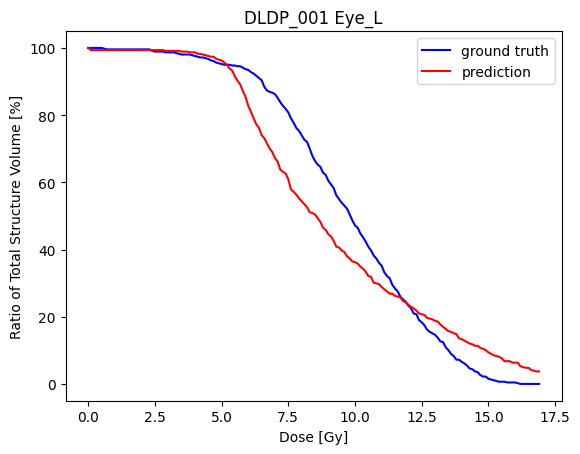

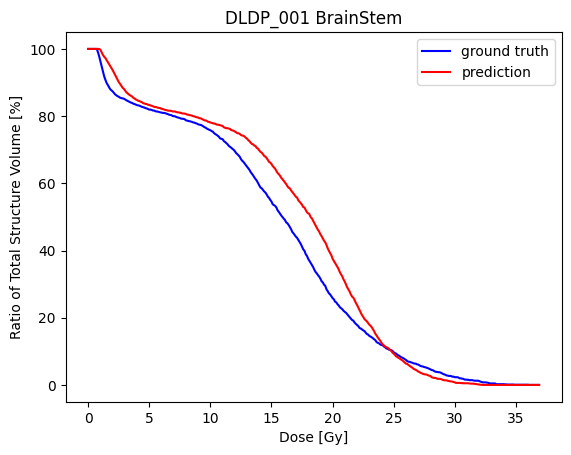

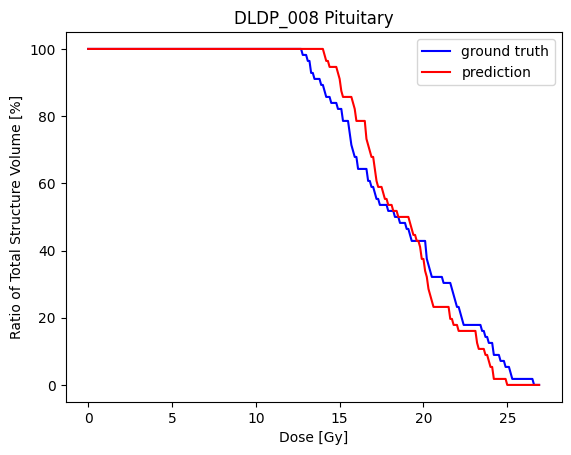

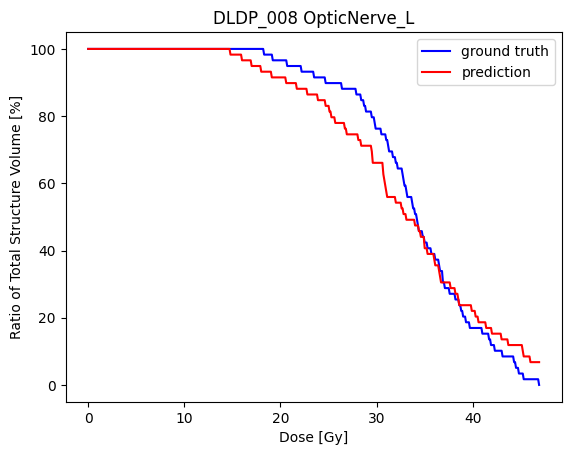

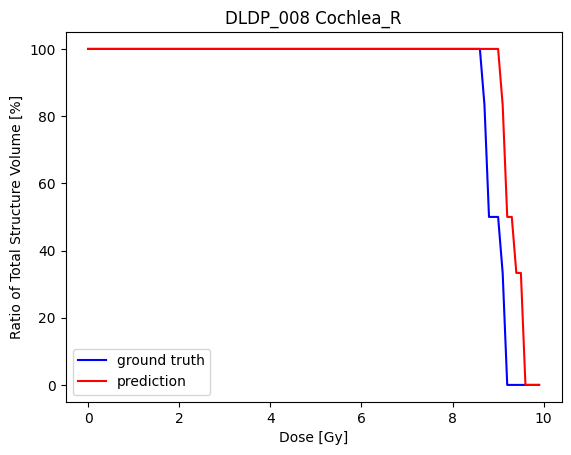

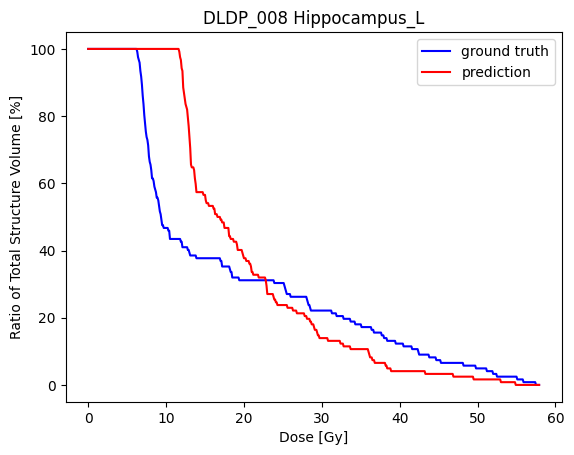

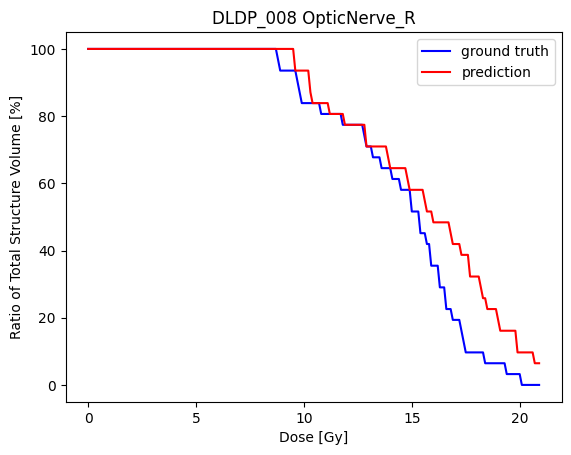

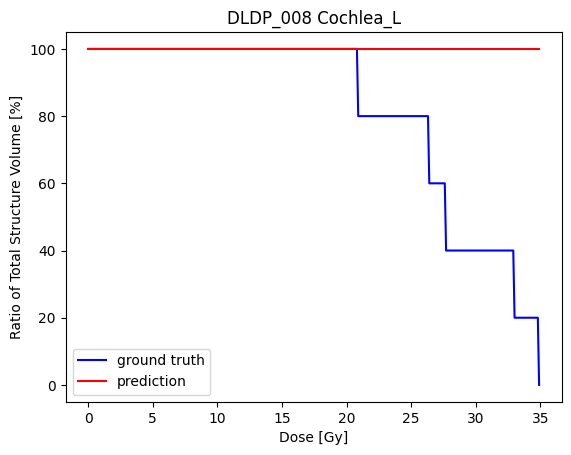

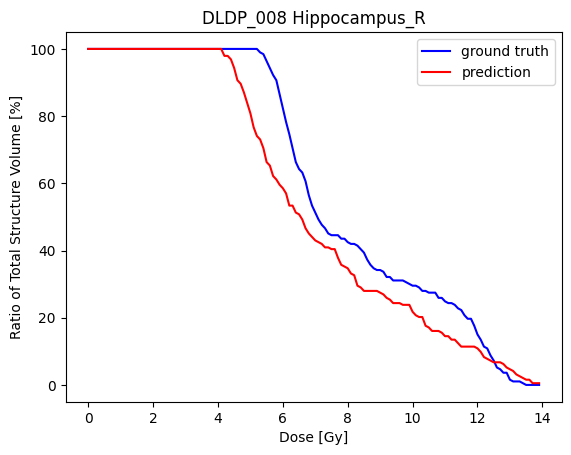

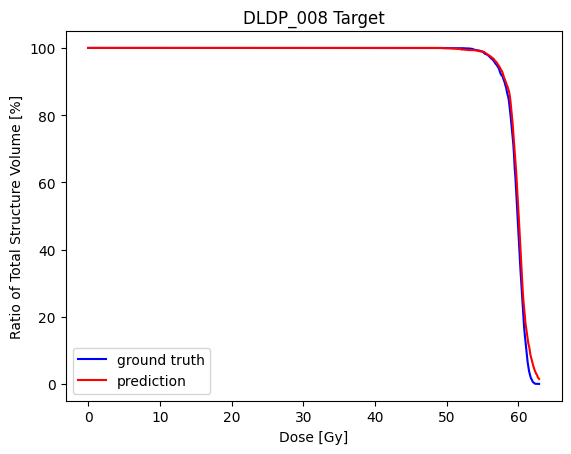

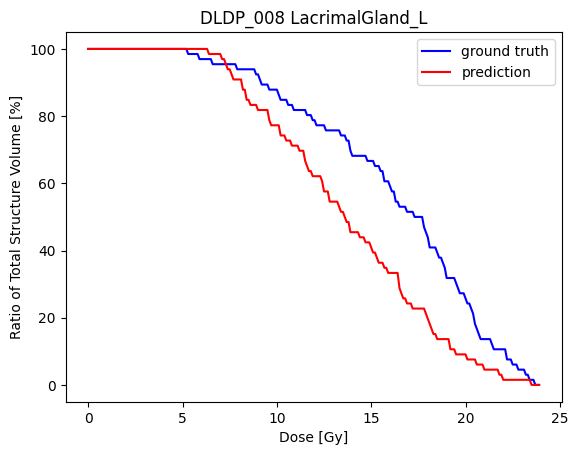

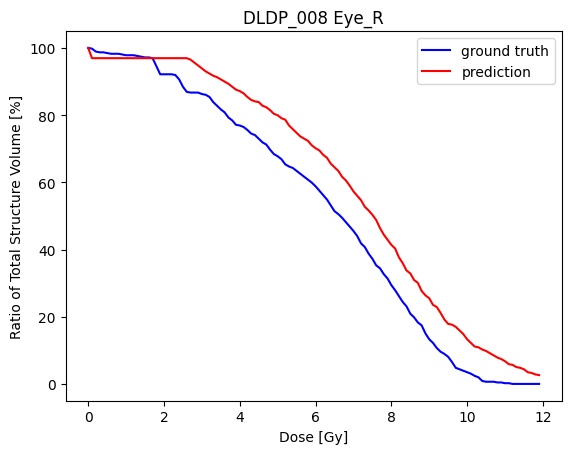

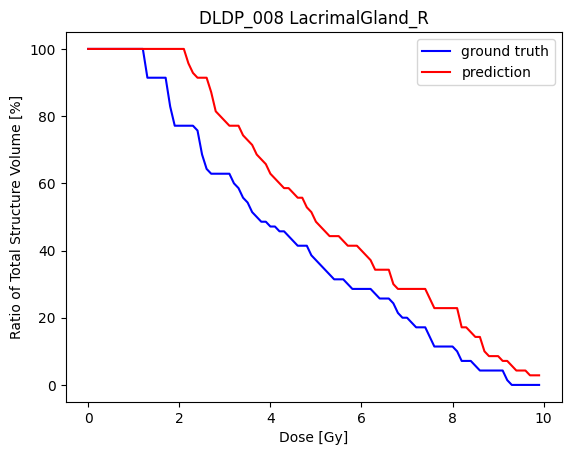

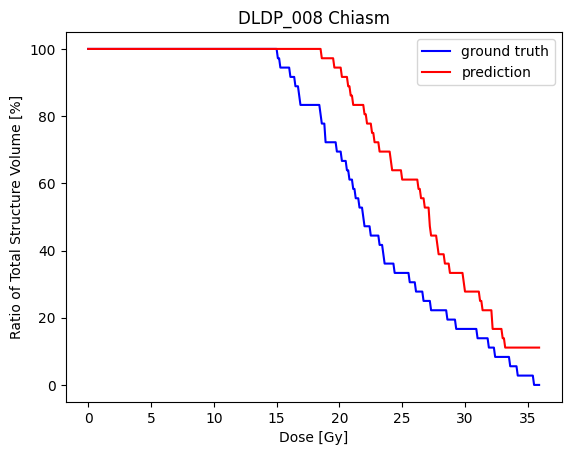

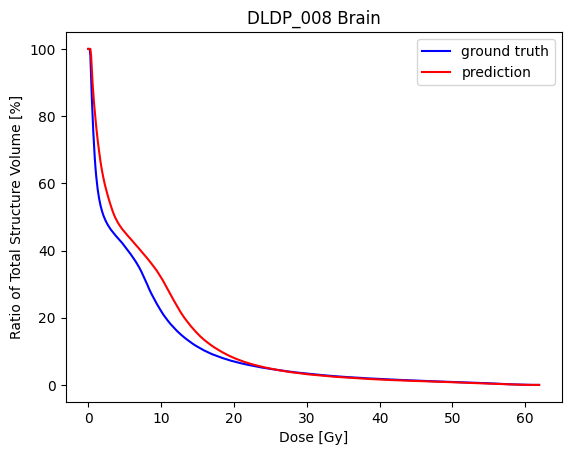

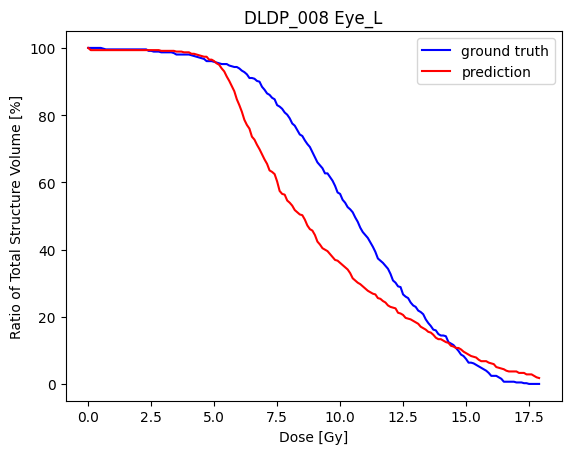

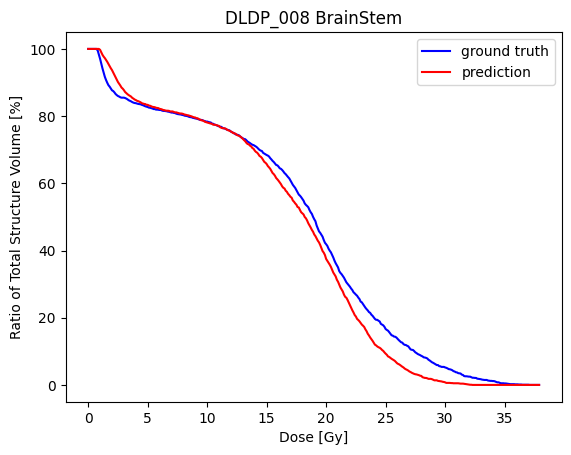

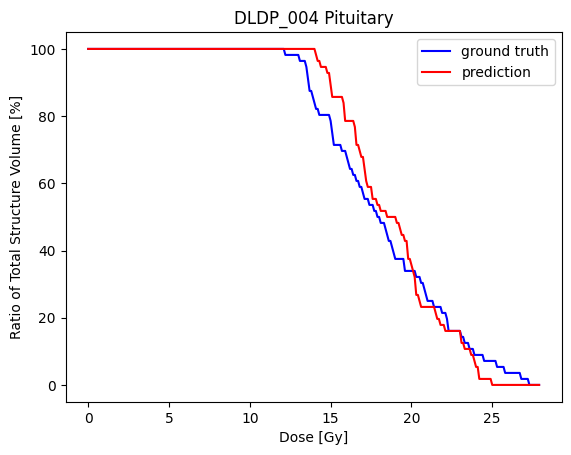

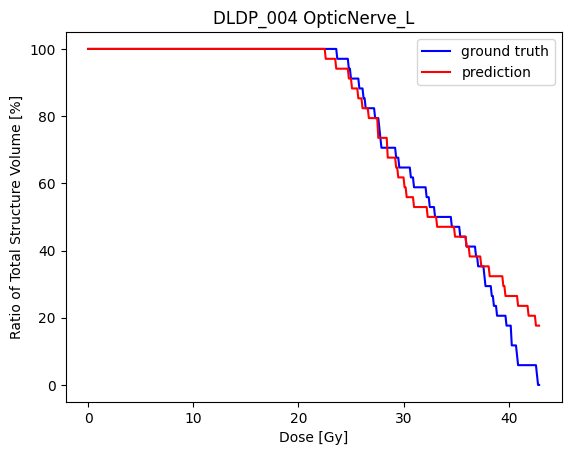

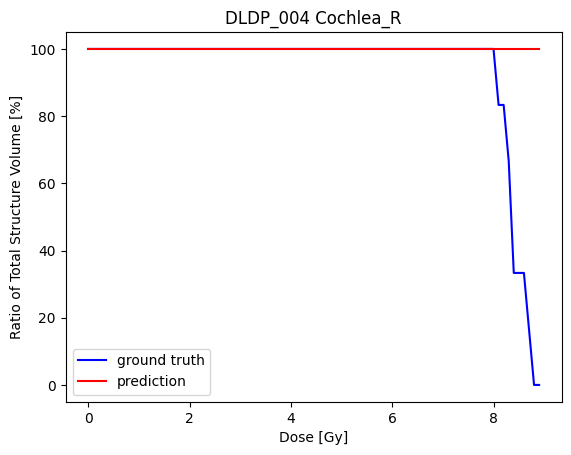

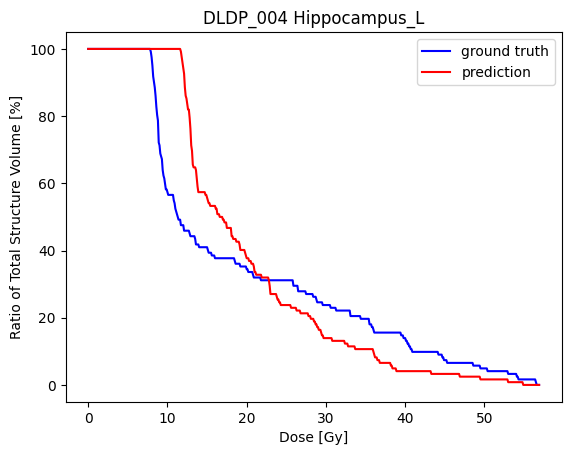

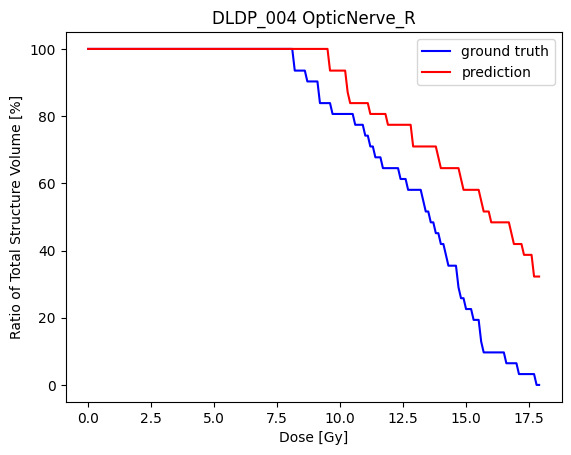

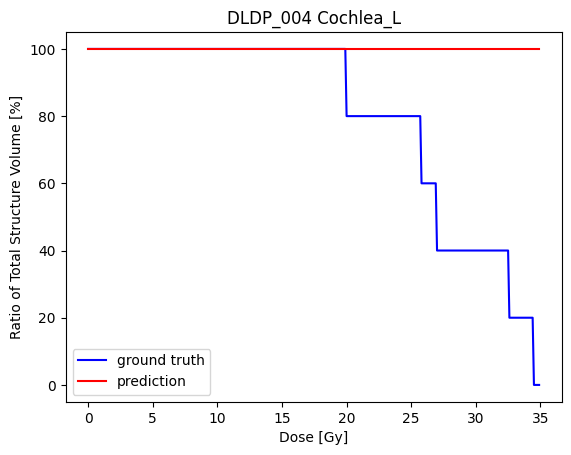

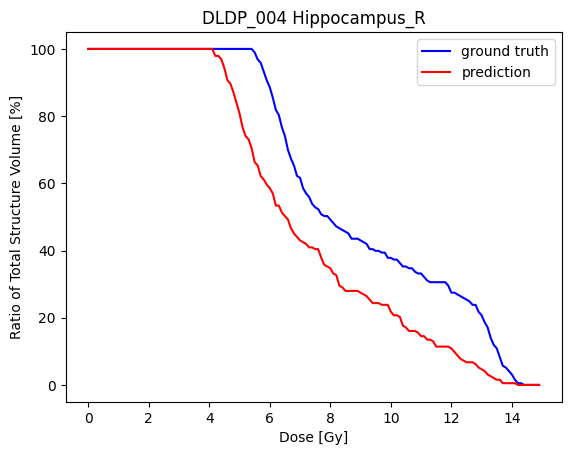

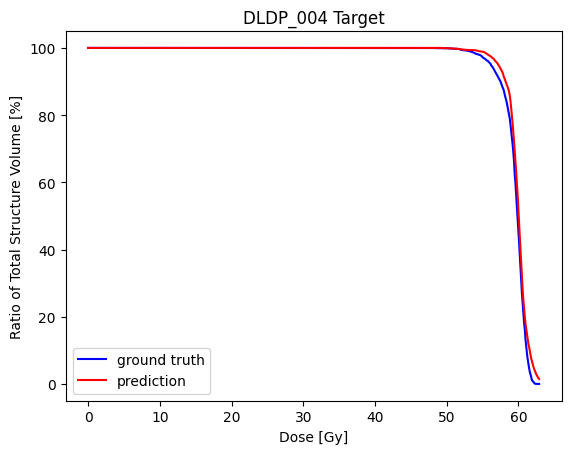

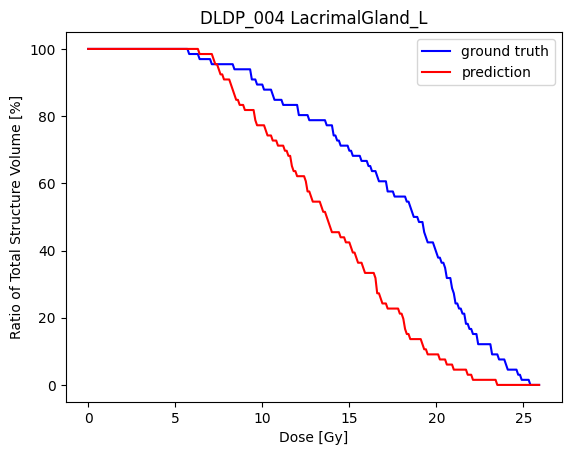

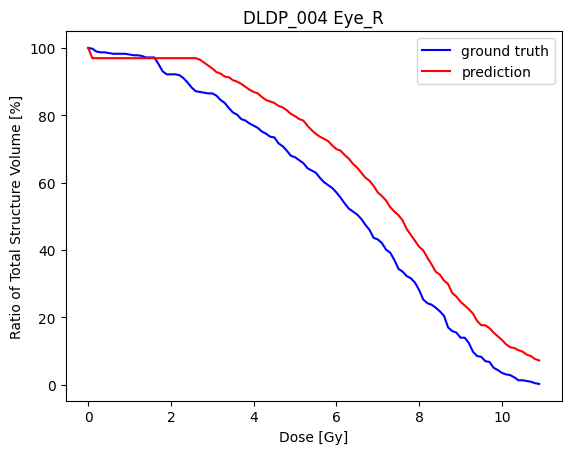

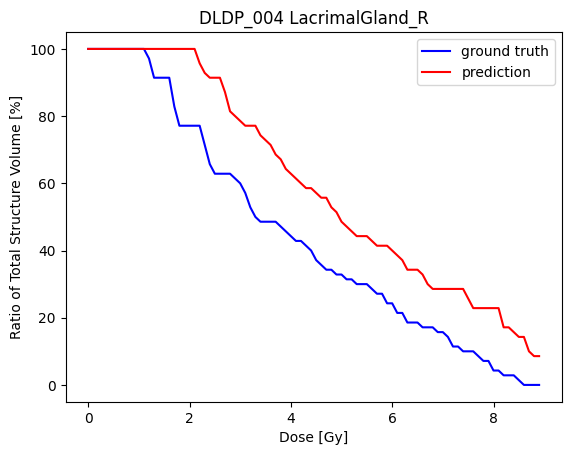

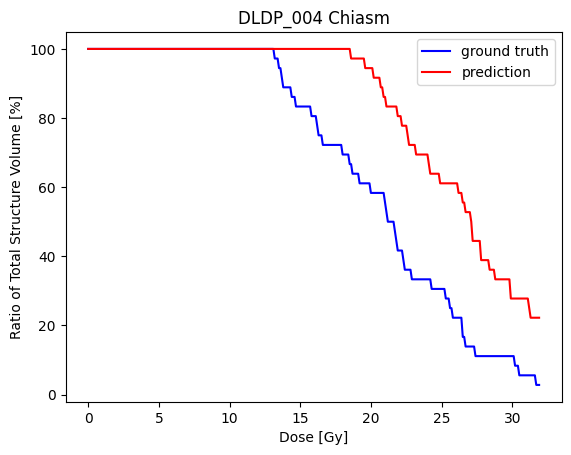

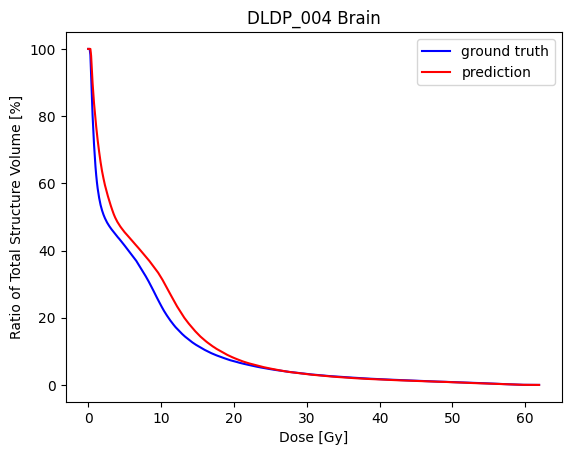

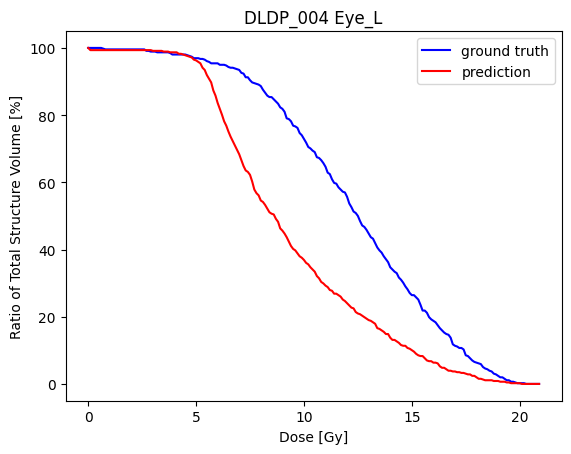

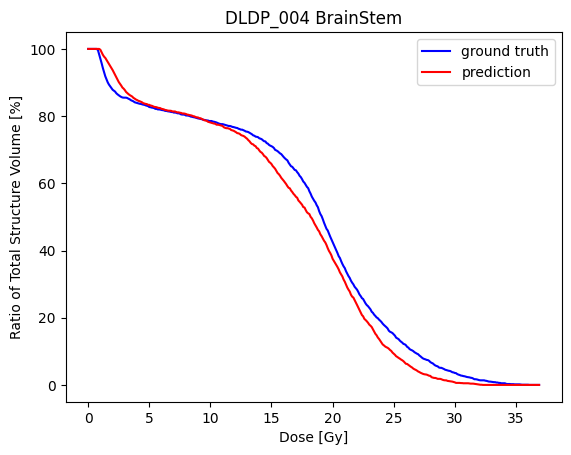

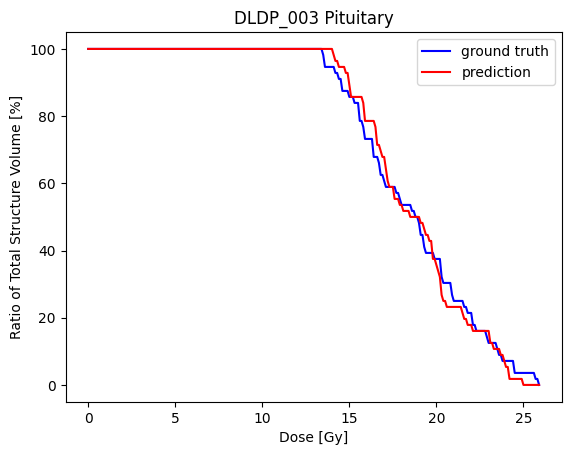

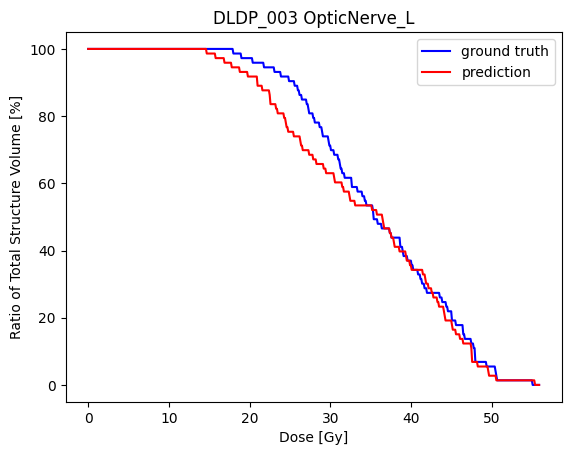

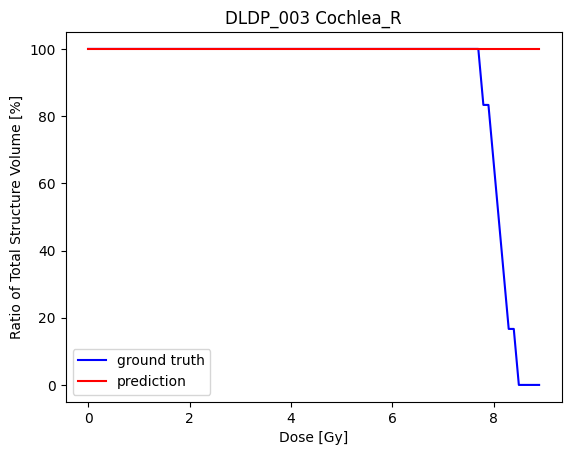

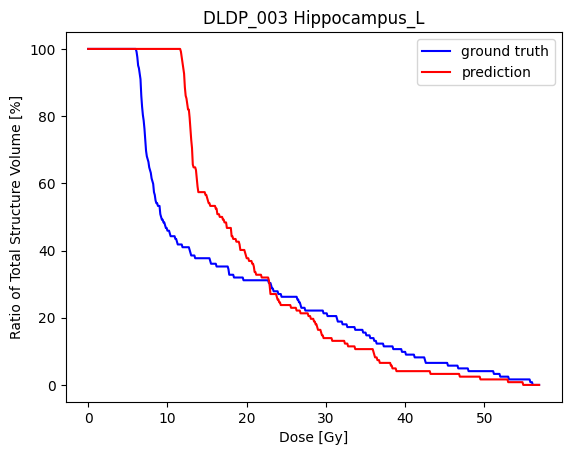

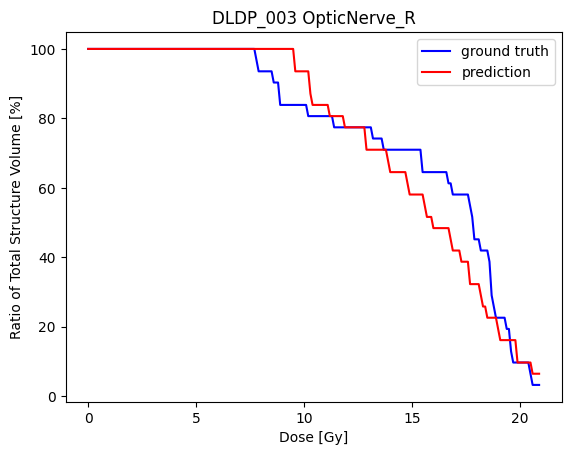

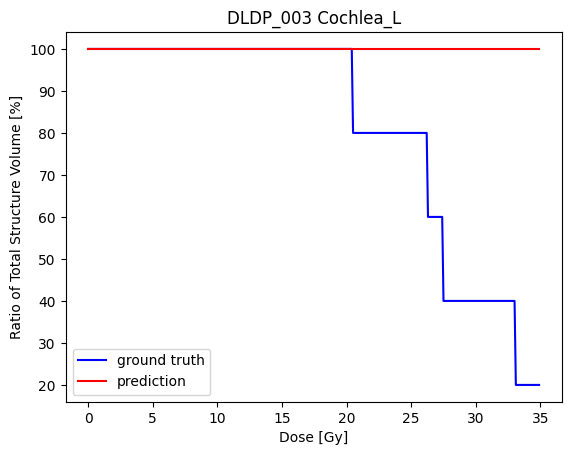

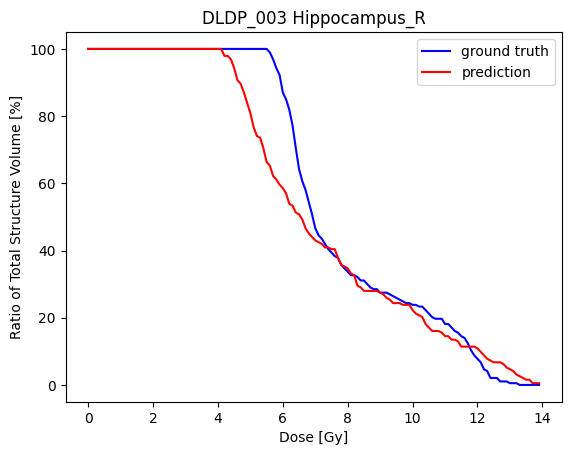

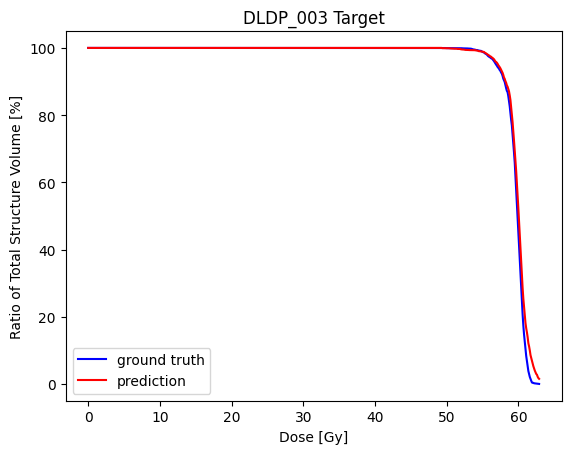

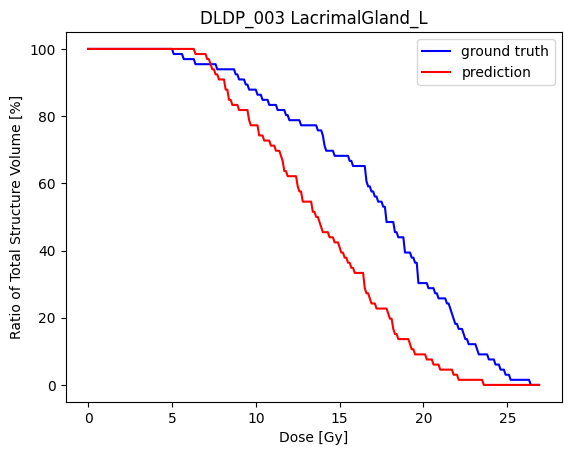

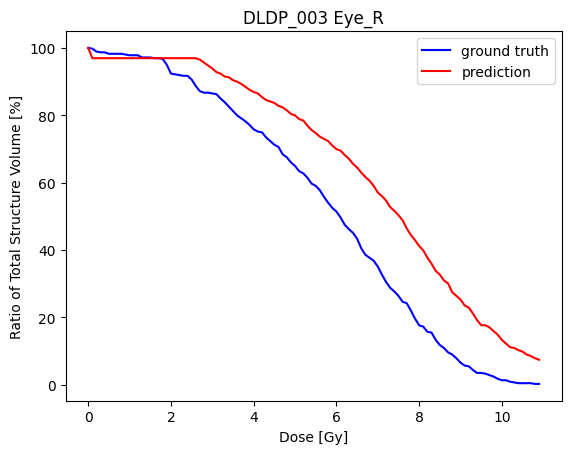

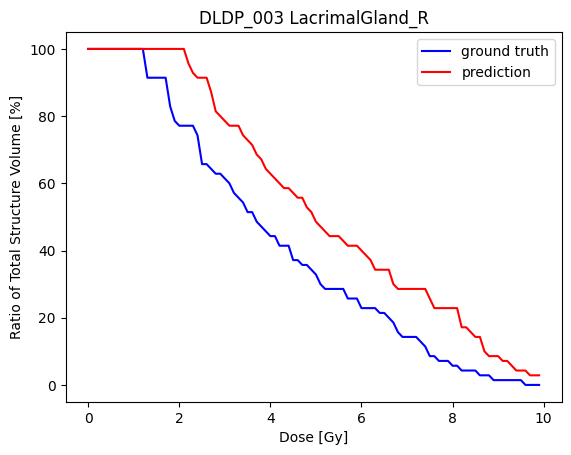

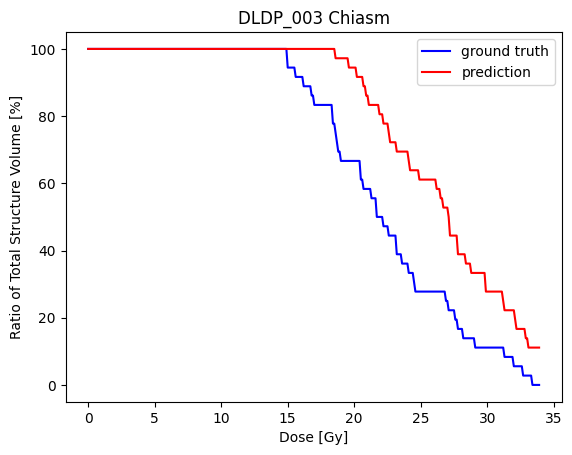

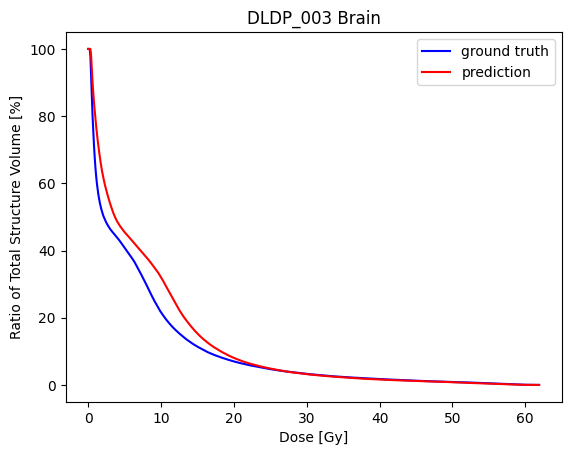

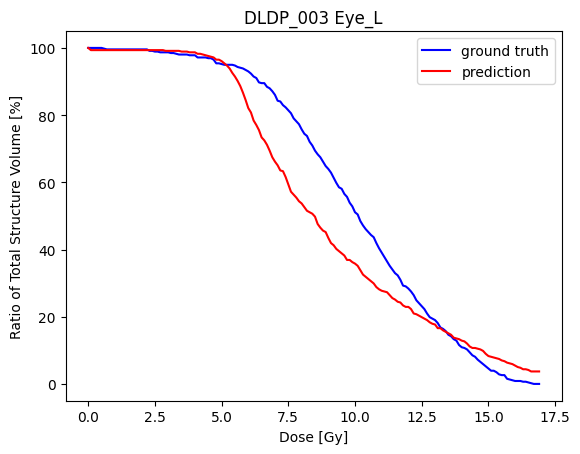

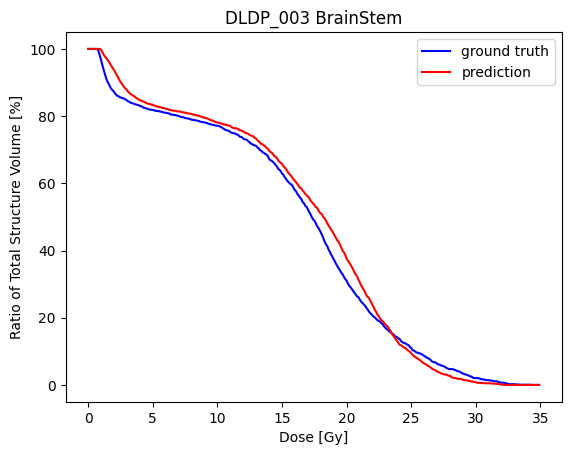

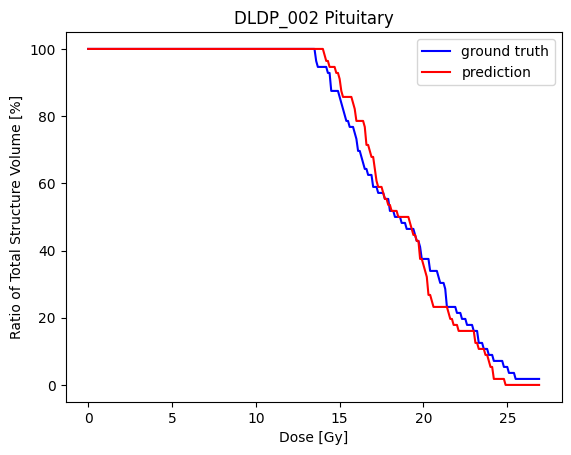

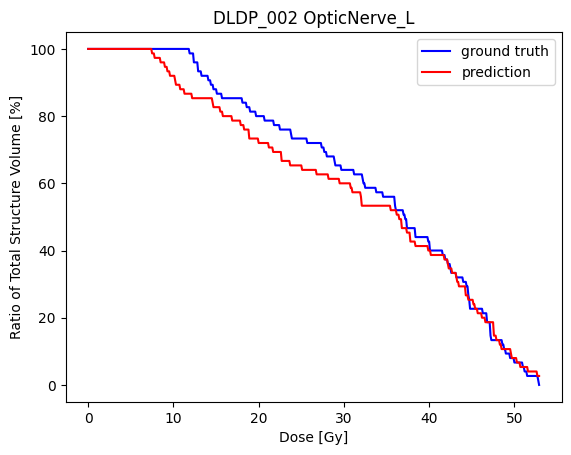

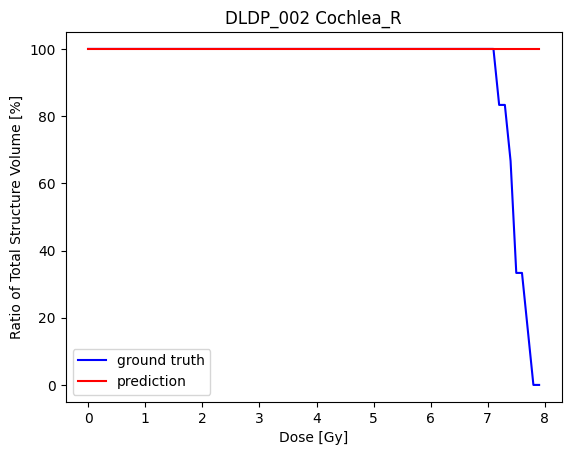

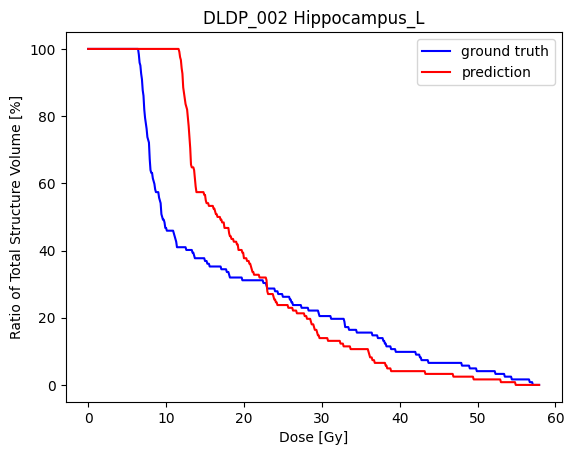

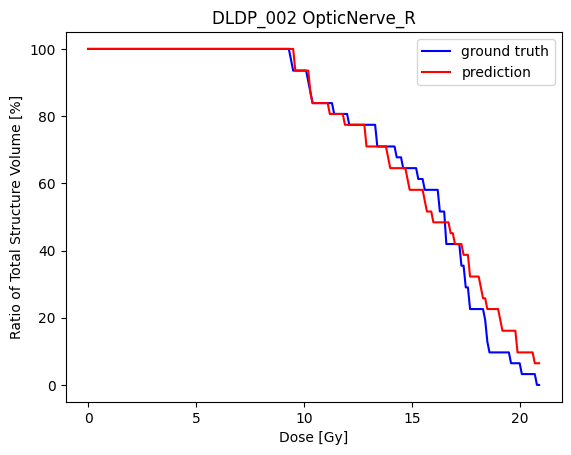

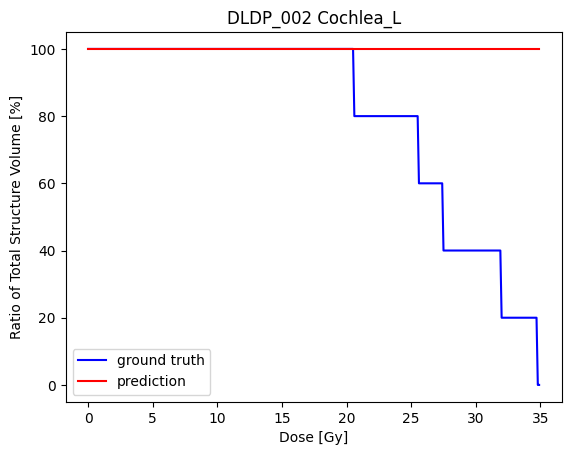

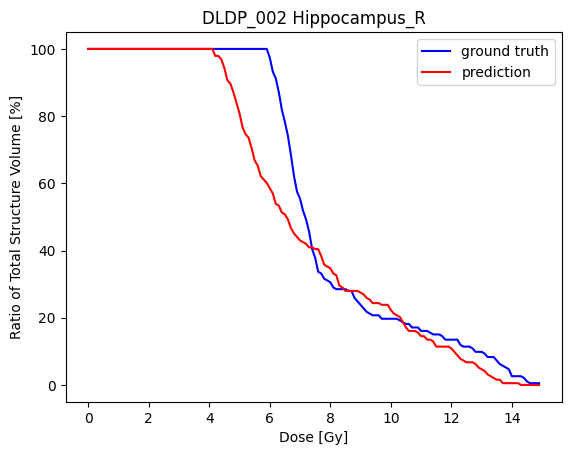

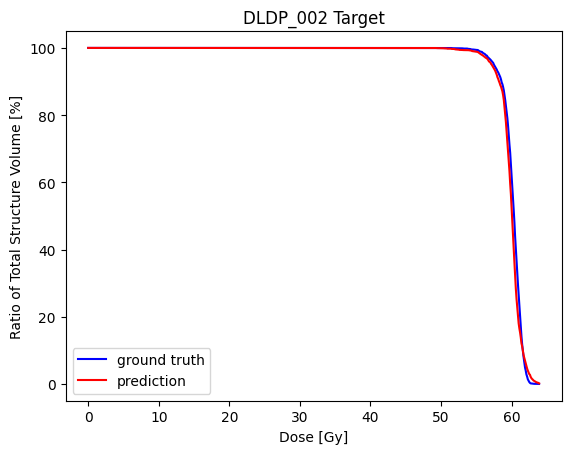

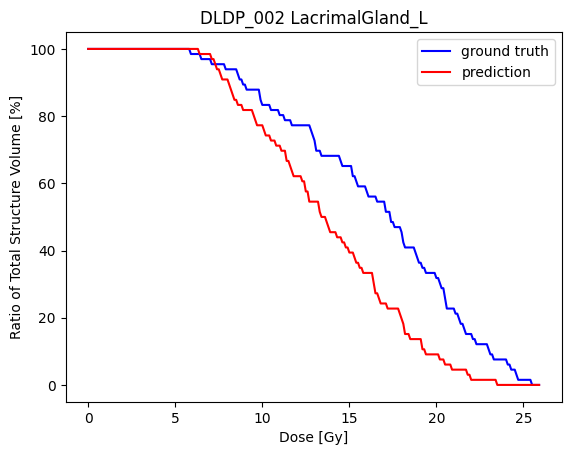

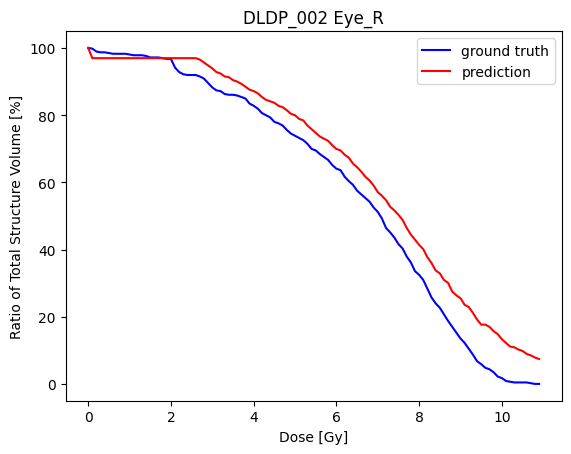

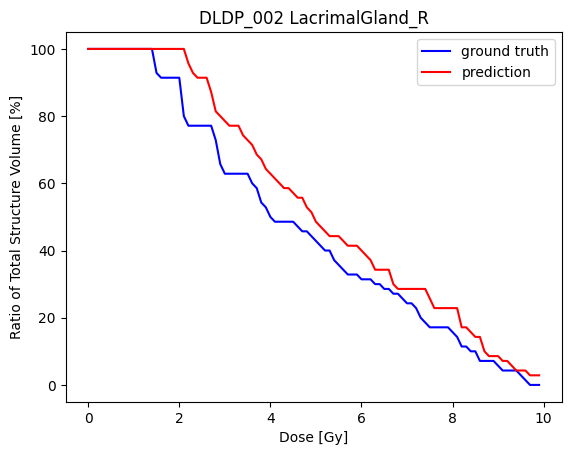

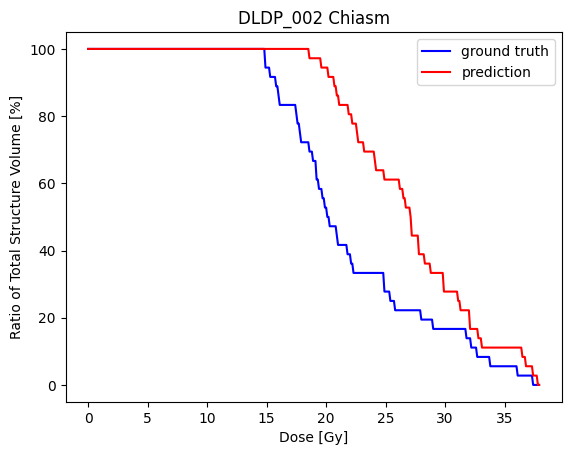

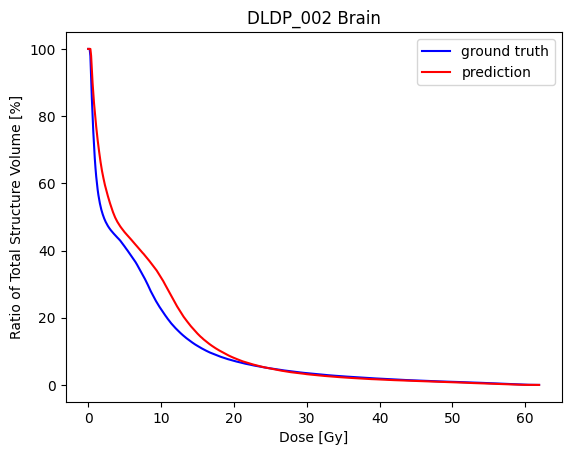

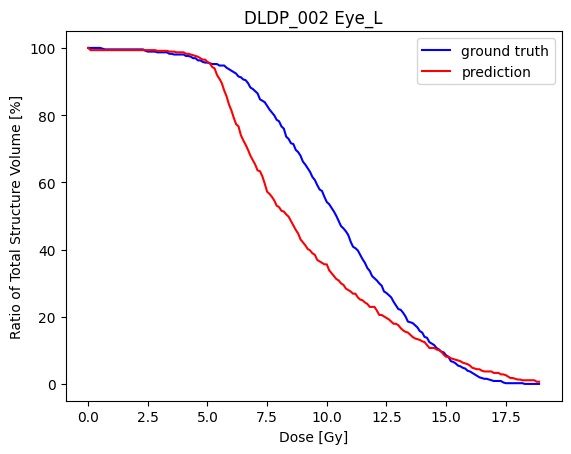

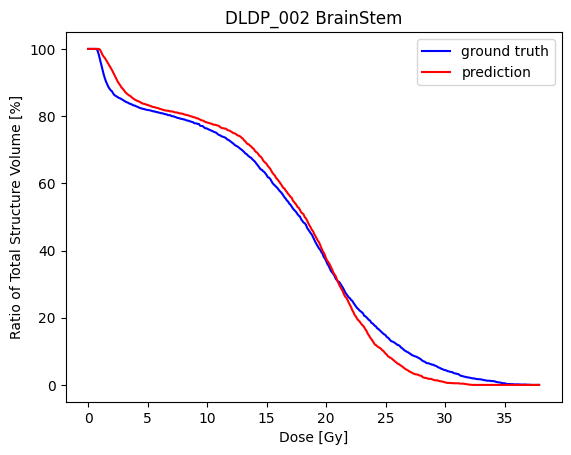

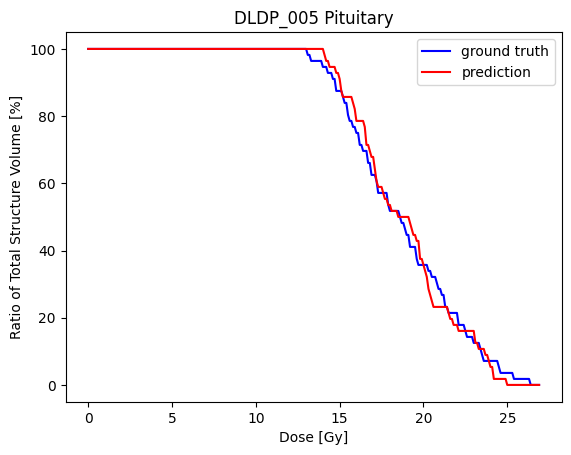

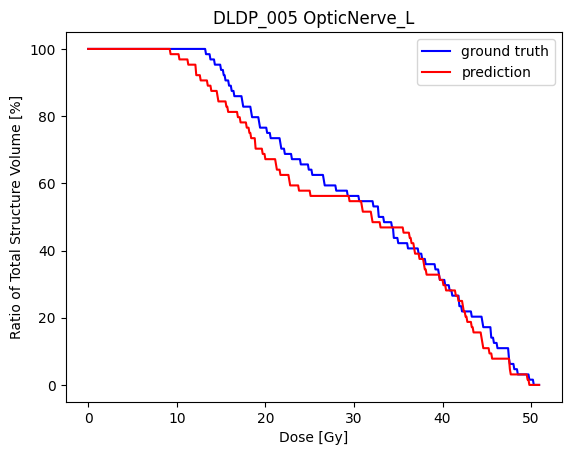

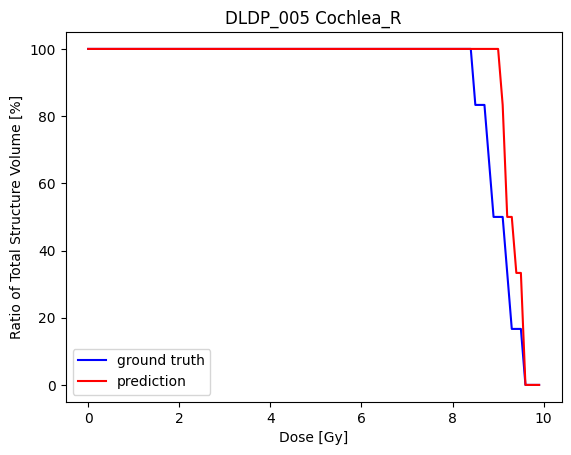

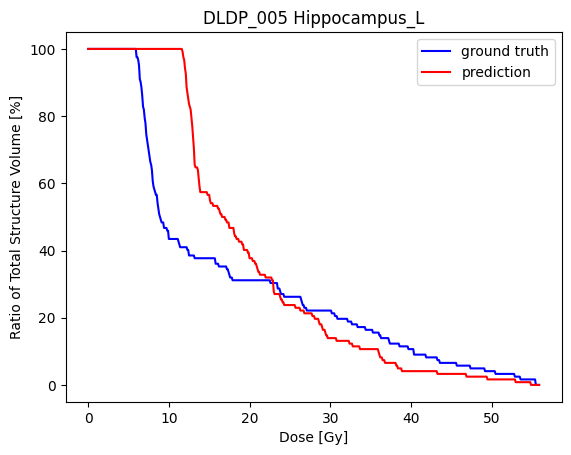

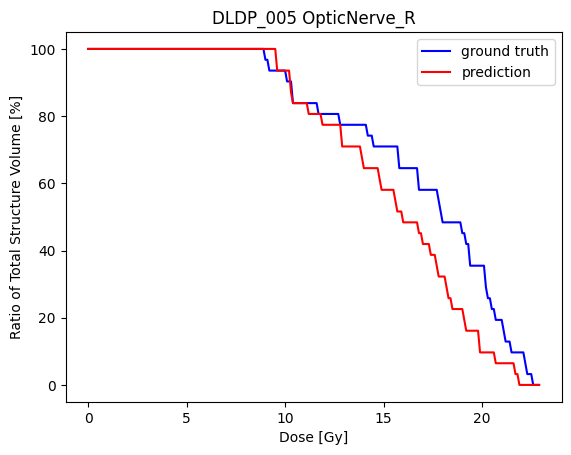

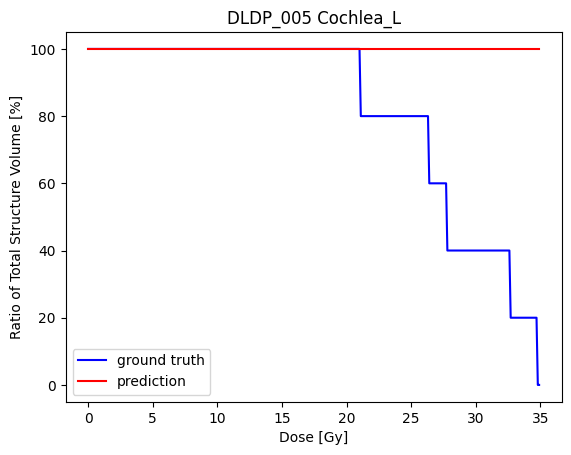

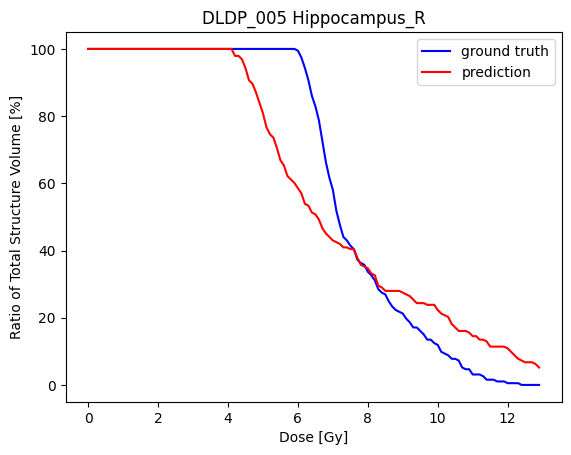

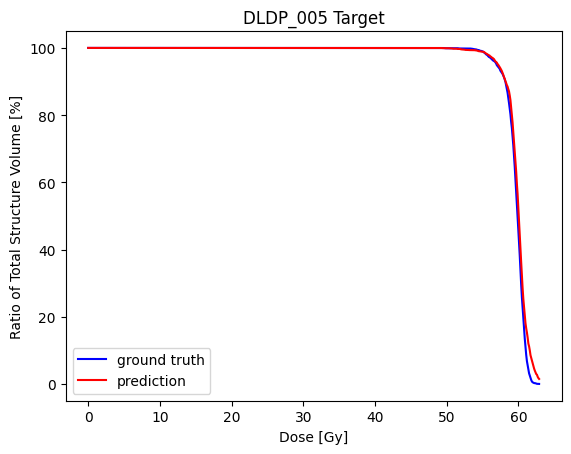

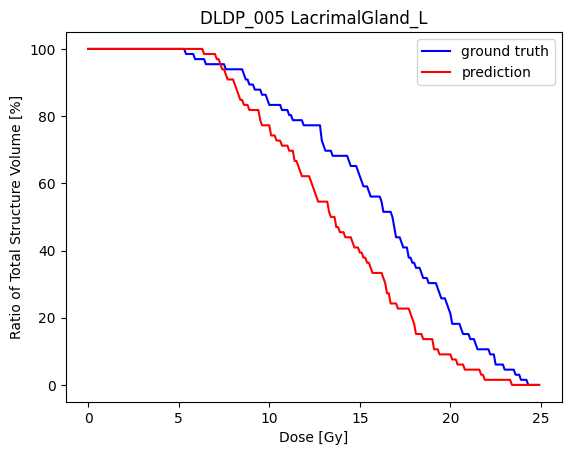

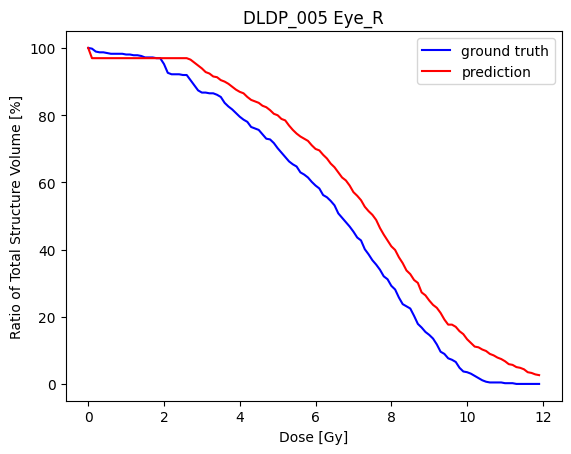

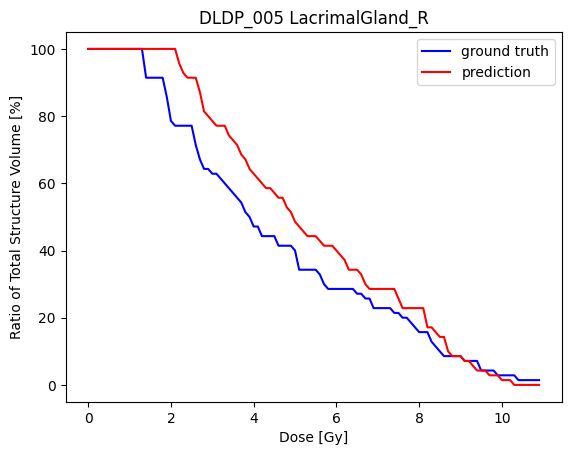

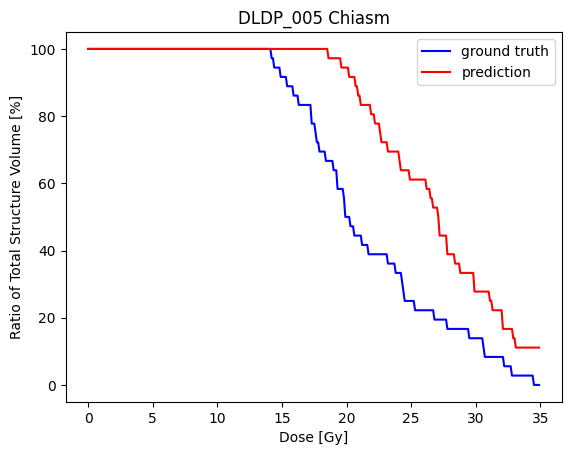

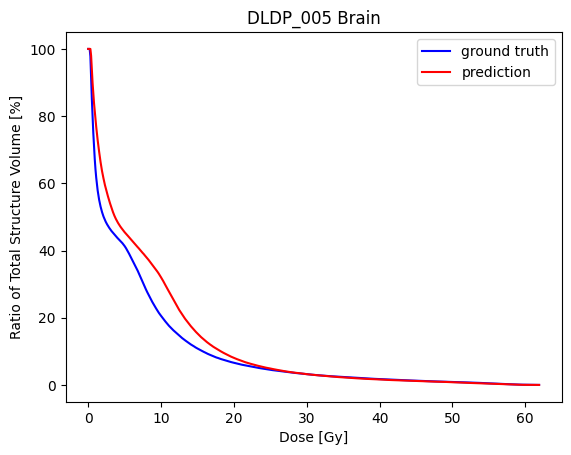

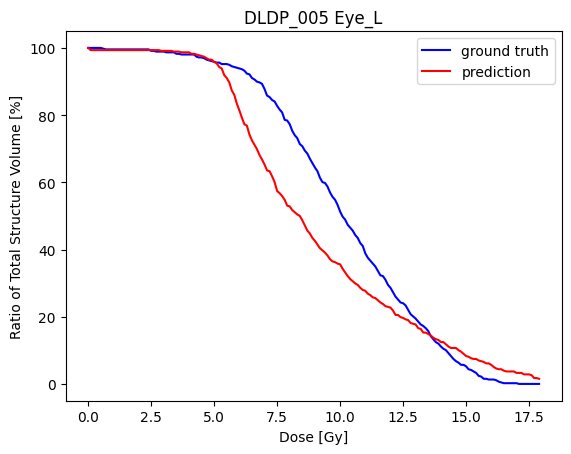

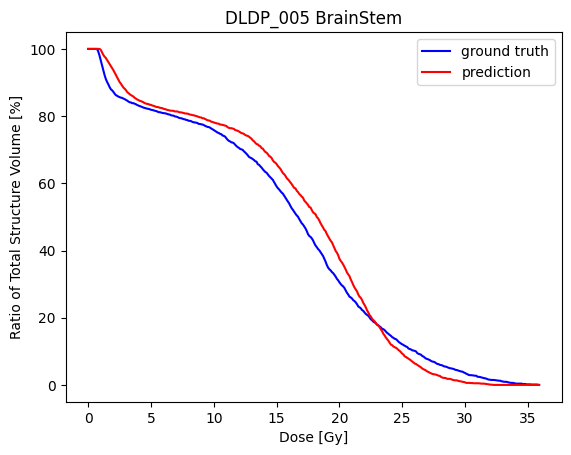

In [9]:
##########   Main   ############

# Output of this script is two dataframes containing all the dose metrics of the targets and oars.
# For each case a pdf file with the DVH curves of each structure comparing the ground truth vs the prediction 
# is constructed.

# define the folder of the data you want to process
data_path = "/Users/amithkamath/repo/deep-planner/data/processed_ONL/"
pred_path = "/Users/amithkamath/repo/deep-planner/data/output_ONL/Prediction/"

# select all cases in the folder
cases = glob.glob(pred_path + "*")

# define a list to store the dataframes for the dose metrics
frames_oars = []
frames_targets = []
case_names = []

for case in cases:
    # select the case number
    case_nr = case.split("/")[-1]
    case_names.append(case_nr)
    
    # open a pdf to save the figures per case
    pdf = matplotlib.backends.backend_pdf.PdfPages(case_nr + "_DVHs.pdf")
    
    # select and read the ground truth dose
    dose_gt_path = glob.glob(os.path.join(data_path, case_nr) + "/Dose.nii.gz")
    dose_gt = sitk.ReadImage(dose_gt_path[0])
    dose_gt = sitk.GetArrayFromImage(dose_gt)
    
    # select and read the predicted dose
    dose_pred_path = glob.glob(os.path.join(pred_path, case_nr) + "/Dose.nii.gz")
    dose_pred = sitk.ReadImage(dose_pred_path[0])
    dose_pred = sitk.GetArrayFromImage(dose_pred)
    
    # select all the structures in the folder
    structures = glob.glob(os.path.join(data_path, case_nr) + "/[!Dose]*")
    
    # define a list to store the dose metrics for the targets and oars
    oars = []
    targets = []
    
    # For every structure calculate the DVHs and dose metrics
    for structure in structures:
        # select the name of the structure
        name = structure.split("/")[-1].split(".")[0]

        # If CT, ignore
        if name == "CT":
            continue
        
        # turn structure into a boolean mask
        struct = sitk.ReadImage(structure)
        mask = sitk.GetArrayFromImage(struct)
        mask = np.array(mask, dtype='bool')
        
        # Select all the dose values of the structures voxels
        dose_array_gt = np.array(dose_gt[mask])
        dose_array_pred = np.array(dose_pred[mask])
        
        # define the dose metrics for the structure
        if "Target" in structure:
            # perform target metrics
            min_dose_gt = np.min(dose_array_gt)
            min_dose_pred = np.min(dose_array_pred)
            mean_dose_gt = np.mean(dose_array_gt)
            mean_dose_pred = np.mean(dose_array_pred)
            D95_gt = ((dose_array_gt > (60*0.95)).sum()/len(dose_array_gt))
            D95_pred = ((dose_array_pred > (60*0.95)).sum()/len(dose_array_pred))
            # safe all target metrics in a list
            targets.append([name, min_dose_gt, min_dose_pred, mean_dose_gt,
                            mean_dose_pred, D95_gt, D95_pred])
        else:
            # perform OAR metrics
            max_dose_gt = np.max(dose_array_gt) 
            max_dose_pred = np.max(dose_array_pred)
            max_dose_1pct_gt = np.sort(dose_array_gt)[round(len(dose_array_gt)*0.99)-1]
            max_dose_1pct_gt = np.sort(dose_array_pred)[round(len(dose_array_pred)*0.99)-1]
            mean_dose_gt = np.mean(dose_array_gt)
            mean_dose_pred = np.mean(dose_array_pred)
            # safe all oar metrics in a list
            oars.append([name, max_dose_gt, max_dose_pred, max_dose_1pct_gt,
                         max_dose_1pct_gt, mean_dose_gt, mean_dose_pred])
        
        # calculate the DVHs
        fig = calc_dvhs(dose_array_gt, dose_array_pred, case_nr, name)
        pdf.savefig(fig)
    
    # convert the lists containing the dose metrics into dataframes
    OARs_DF = pd.DataFrame(oars, columns = ["structure", "max_dose_gt", "max_dose_pred", "max_dose_1pct_gt",
                                            "max_dose_1pct_gt", "mean_dose_gt", "mean_dose_pred"])
    Target_DF = pd.DataFrame(targets, columns = ["structure", "min_dose_gt", "min_dose_pred", "mean_dose_gt",
                                                 "mean_dose_pred", "D95_gt", "D95_pred"])
    # save the dataframes of each case into a list
    frames_oars.append(OARs_DF)
    frames_targets.append(OARs_DF)
    
    # close the pdf containing the DVHs that has been constructed per case 
    pdf.close()
    
# concatenate all dataframes in a single dataframe and save as pickle file.
OAR_metrics = pd.concat(frames_oars, keys = case_names)
OAR_metrics.to_pickle("OAR_metrics.pkl")
Target_metrics = pd.concat(frames_targets, keys = case_names)
Target_metrics.to_pickle("Target_metrics.pkl")